In [63]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='2'

import math
import torch
import numpy
import timm
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms


#
# Stochastic inplace weight (SIW) dropout is further experimented here.
#
# Antorbus

In [64]:
torch.cuda.is_available()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [65]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize([0.49, 0.48 ,0.45], [0.25,0.24,0.26])])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [66]:
prlist=[]
arch='vit_tiny_patch16_224'
model = timm.create_model(arch)
for name, param in model.named_parameters():
    if param.requires_grad and param.ndim==2:
        prlist.append(name)


In [67]:
prlist #List containing the names of the weights of all the fully connected layers in VIT 

['blocks.0.attn.qkv.weight',
 'blocks.0.attn.proj.weight',
 'blocks.0.mlp.fc1.weight',
 'blocks.0.mlp.fc2.weight',
 'blocks.1.attn.qkv.weight',
 'blocks.1.attn.proj.weight',
 'blocks.1.mlp.fc1.weight',
 'blocks.1.mlp.fc2.weight',
 'blocks.2.attn.qkv.weight',
 'blocks.2.attn.proj.weight',
 'blocks.2.mlp.fc1.weight',
 'blocks.2.mlp.fc2.weight',
 'blocks.3.attn.qkv.weight',
 'blocks.3.attn.proj.weight',
 'blocks.3.mlp.fc1.weight',
 'blocks.3.mlp.fc2.weight',
 'blocks.4.attn.qkv.weight',
 'blocks.4.attn.proj.weight',
 'blocks.4.mlp.fc1.weight',
 'blocks.4.mlp.fc2.weight',
 'blocks.5.attn.qkv.weight',
 'blocks.5.attn.proj.weight',
 'blocks.5.mlp.fc1.weight',
 'blocks.5.mlp.fc2.weight',
 'blocks.6.attn.qkv.weight',
 'blocks.6.attn.proj.weight',
 'blocks.6.mlp.fc1.weight',
 'blocks.6.mlp.fc2.weight',
 'blocks.7.attn.qkv.weight',
 'blocks.7.attn.proj.weight',
 'blocks.7.mlp.fc1.weight',
 'blocks.7.mlp.fc2.weight',
 'blocks.8.attn.qkv.weight',
 'blocks.8.attn.proj.weight',
 'blocks.8.mlp.fc1.we

In [68]:
# SIW dropout (shown in this function) randomly sets a specified percentage of weights in a layer to zero and 
# scales the rest of the weights accordingly (to make them smaller)
def weight_change_v1(net, p_dropout=0.02): 
    with torch.no_grad():
        for name, param in net.named_parameters():
            if name in prlist:
                param /= (1./(1.-p_dropout)) 
                # Other scaling methods need to be tested such as:
                # /= (1./ math.sqrt(1.-p_dropout)) <--- not tested
                # *= (1./(1.-p_dropout)) <--- this scaling hinders performance 
                # *= (1./(1.- math.sqrt(p_dropout))) <--- not tested 
                # *= 1 <--- tested only on smaller networks
                n_weights = param.numel()
                n_weights_to_change = math.ceil(n_weights * p_dropout)
                idx = torch.randint(n_weights,(n_weights_to_change,))
                param_flattened = param.flatten()
                param_flattened[idx]=0

In [69]:
def test(model, criterion):
    with torch.no_grad():
        model.eval()
        correct, total, v_loss = 0, 0, 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            v_loss += loss.item()*data.size(0)
            _, pred = torch.max(output, 1)
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += target.shape[0]
        v_loss = v_loss/total
        acc=correct/total
        print(f'Validation accuracy: {acc*100:.3f}% Valid loss: {v_loss:.6f}\n')
    return float(acc), v_loss

In [70]:
def train(model, epochs, optimizer, criterion, p_SIWdropout = None, SIWdropout_rate = 0):
    model.to(device)
    results = {
        'Train_loss' : [],
        'Valid_loss' : [],
        'Valid_accuracy' : []
    }
    for epoch in range(1, epochs+1):
        train_loss = 0.0

        if p_SIWdropout and  epoch%SIWdropout_rate == 0:
            weight_change_v1(model, p_dropout= p_SIWdropout)
            print('Performing SIW dropout...')

        model.train()
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        train_loss = train_loss/len(train_loader.dataset)
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')
        acc, v_loss = test(model, criterion)
        results['Train_loss'].append(train_loss)
        results['Valid_loss'].append(v_loss)
        results['Valid_accuracy'].append(acc)
    return results

In [71]:
def experiment(p_SIWdropout = None, SIWdropout_rate = 0, num_epochs=20, learning_rate = 0.001):
    net = timm.create_model(arch, pretrained=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    # Diffrent optimizers and learning rates should be tested 
    # Networks that are not pretrained should also be tested 
    criterion = torch.nn.CrossEntropyLoss()
    return train(net, num_epochs, optimizer, criterion, p_SIWdropout, SIWdropout_rate)

In [83]:
# Five vanilla VIT networks will be trained to account for randomness in the training process. Training will this 
# time be done for 30 epochs.
results_vanilla_30 = [experiment(num_epochs=30) for _ in range(5)]   

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.35it/s]

Epoch: 1 	Training Loss: 1.648575


Validation accuracy: 49.330% Valid loss: 1.341923



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.62it/s]

Epoch: 2 	Training Loss: 1.214742


Validation accuracy: 58.480% Valid loss: 1.157965



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.35it/s]

Epoch: 3 	Training Loss: 1.044004


Validation accuracy: 66.020% Valid loss: 0.948852



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.06it/s]

Epoch: 4 	Training Loss: 0.915978


Validation accuracy: 67.900% Valid loss: 0.901655



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.96it/s]

Epoch: 5 	Training Loss: 0.820565


Validation accuracy: 70.690% Valid loss: 0.829247



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.17it/s]

Epoch: 6 	Training Loss: 0.731250


Validation accuracy: 71.800% Valid loss: 0.804539



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]

Epoch: 7 	Training Loss: 0.665807


Validation accuracy: 72.110% Valid loss: 0.771837



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.84it/s]

Epoch: 8 	Training Loss: 0.598988


Validation accuracy: 75.430% Valid loss: 0.702662



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.62it/s]

Epoch: 9 	Training Loss: 0.539135


Validation accuracy: 75.520% Valid loss: 0.724425



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.28it/s]

Epoch: 10 	Training Loss: 0.489217


Validation accuracy: 76.650% Valid loss: 0.677411



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.72it/s]

Epoch: 11 	Training Loss: 0.437681


Validation accuracy: 77.460% Valid loss: 0.672946



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.43it/s]

Epoch: 12 	Training Loss: 0.389869


Validation accuracy: 77.700% Valid loss: 0.679962



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.38it/s]


Epoch: 13 	Training Loss: 0.352849
Validation accuracy: 76.710% Valid loss: 0.729781



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.28it/s]

Epoch: 14 	Training Loss: 0.312059


Validation accuracy: 77.770% Valid loss: 0.711278



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.49it/s]

Epoch: 15 	Training Loss: 0.278465


Validation accuracy: 77.410% Valid loss: 0.744614



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 16 	Training Loss: 0.248296


Validation accuracy: 76.320% Valid loss: 0.820885



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.80it/s]

Epoch: 17 	Training Loss: 0.231976


Validation accuracy: 77.520% Valid loss: 0.813034



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.35it/s]

Epoch: 18 	Training Loss: 0.205377


Validation accuracy: 78.040% Valid loss: 0.756102



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.09it/s]

Epoch: 19 	Training Loss: 0.184375


Validation accuracy: 78.400% Valid loss: 0.809477



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.77it/s]

Epoch: 20 	Training Loss: 0.168811


Validation accuracy: 78.040% Valid loss: 0.823360



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.88it/s]

Epoch: 21 	Training Loss: 0.157583


Validation accuracy: 78.310% Valid loss: 0.859375



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.58it/s]

Epoch: 22 	Training Loss: 0.146166


Validation accuracy: 76.850% Valid loss: 0.921808



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.27it/s]

Epoch: 23 	Training Loss: 0.135177


Validation accuracy: 78.250% Valid loss: 0.859562



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.77it/s]

Epoch: 24 	Training Loss: 0.129817


Validation accuracy: 78.560% Valid loss: 0.879393



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 25 	Training Loss: 0.121736


Validation accuracy: 76.880% Valid loss: 0.899929



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.29it/s]

Epoch: 26 	Training Loss: 0.115808


Validation accuracy: 78.300% Valid loss: 0.864907



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.27it/s]

Epoch: 27 	Training Loss: 0.111678


Validation accuracy: 77.750% Valid loss: 0.916574



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.46it/s]

Epoch: 28 	Training Loss: 0.101591


Validation accuracy: 76.870% Valid loss: 0.976556



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.24it/s]

Epoch: 29 	Training Loss: 0.096409


Validation accuracy: 78.170% Valid loss: 0.979238



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.52it/s]

Epoch: 30 	Training Loss: 0.098260


Validation accuracy: 78.790% Valid loss: 0.905353



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 1 	Training Loss: 1.463845


Validation accuracy: 57.450% Valid loss: 1.145140



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.54it/s]

Epoch: 2 	Training Loss: 1.014281


Validation accuracy: 64.340% Valid loss: 0.992290



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.24it/s]

Epoch: 3 	Training Loss: 0.857159


Validation accuracy: 67.860% Valid loss: 0.908096



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.94it/s]

Epoch: 4 	Training Loss: 0.748322


Validation accuracy: 73.860% Valid loss: 0.778672



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.00it/s]

Epoch: 5 	Training Loss: 0.660598


Validation accuracy: 76.560% Valid loss: 0.670103



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.96it/s]

Epoch: 6 	Training Loss: 0.590945


Validation accuracy: 76.970% Valid loss: 0.665705



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.54it/s]

Epoch: 7 	Training Loss: 0.528780


Validation accuracy: 77.690% Valid loss: 0.631614



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.88it/s]

Epoch: 8 	Training Loss: 0.471019


Validation accuracy: 80.460% Valid loss: 0.568076



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.23it/s]

Epoch: 9 	Training Loss: 0.427900


Validation accuracy: 79.780% Valid loss: 0.600953



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.29it/s]

Epoch: 10 	Training Loss: 0.380659


Validation accuracy: 79.650% Valid loss: 0.642549



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.22it/s]

Epoch: 11 	Training Loss: 0.341598


Validation accuracy: 79.290% Valid loss: 0.643608



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.17it/s]

Epoch: 12 	Training Loss: 0.311560


Validation accuracy: 80.400% Valid loss: 0.591664



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.06it/s]

Epoch: 13 	Training Loss: 0.266482


Validation accuracy: 80.840% Valid loss: 0.601986



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 14 	Training Loss: 0.242779


Validation accuracy: 80.850% Valid loss: 0.632296



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.70it/s]

Epoch: 15 	Training Loss: 0.217882


Validation accuracy: 80.370% Valid loss: 0.667383



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.88it/s]

Epoch: 16 	Training Loss: 0.200531


Validation accuracy: 82.030% Valid loss: 0.597072



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.71it/s]

Epoch: 17 	Training Loss: 0.179555


Validation accuracy: 80.770% Valid loss: 0.640739



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.44it/s]

Epoch: 18 	Training Loss: 0.165454


Validation accuracy: 80.870% Valid loss: 0.672196



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.56it/s]

Epoch: 19 	Training Loss: 0.146394


Validation accuracy: 82.270% Valid loss: 0.688544



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.29it/s]

Epoch: 20 	Training Loss: 0.143100


Validation accuracy: 80.600% Valid loss: 0.700240



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.43it/s]

Epoch: 21 	Training Loss: 0.128528


Validation accuracy: 81.130% Valid loss: 0.757829



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.16it/s]

Epoch: 22 	Training Loss: 0.128611


Validation accuracy: 81.660% Valid loss: 0.702176



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.50it/s]

Epoch: 23 	Training Loss: 0.110997


Validation accuracy: 81.240% Valid loss: 0.741813



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.24it/s]

Epoch: 24 	Training Loss: 0.108878


Validation accuracy: 80.870% Valid loss: 0.724588



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.56it/s]


Epoch: 25 	Training Loss: 0.102706
Validation accuracy: 81.710% Valid loss: 0.764144



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.29it/s]

Epoch: 26 	Training Loss: 0.099016


Validation accuracy: 81.610% Valid loss: 0.789191



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.95it/s]

Epoch: 27 	Training Loss: 0.090984


Validation accuracy: 80.810% Valid loss: 0.830724



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.09it/s]

Epoch: 28 	Training Loss: 0.087856


Validation accuracy: 81.360% Valid loss: 0.815400



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 22.99it/s]

Epoch: 29 	Training Loss: 0.091932


Validation accuracy: 80.790% Valid loss: 0.755616



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.90it/s]

Epoch: 30 	Training Loss: 0.081982


Validation accuracy: 81.610% Valid loss: 0.834626



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.97it/s]

Epoch: 1 	Training Loss: 1.526927


Validation accuracy: 54.420% Valid loss: 1.216928



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.76it/s]


Epoch: 2 	Training Loss: 1.090149
Validation accuracy: 61.800% Valid loss: 1.064609



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.41it/s]

Epoch: 3 	Training Loss: 0.912648


Validation accuracy: 69.260% Valid loss: 0.864372



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.98it/s]

Epoch: 4 	Training Loss: 0.794983


Validation accuracy: 72.040% Valid loss: 0.783566



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.04it/s]

Epoch: 5 	Training Loss: 0.704149


Validation accuracy: 71.670% Valid loss: 0.803224



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.49it/s]

Epoch: 6 	Training Loss: 0.624474


Validation accuracy: 76.190% Valid loss: 0.670205



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.43it/s]

Epoch: 7 	Training Loss: 0.557363


Validation accuracy: 75.950% Valid loss: 0.682309



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.32it/s]

Epoch: 8 	Training Loss: 0.503420


Validation accuracy: 76.470% Valid loss: 0.682354



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.27it/s]

Epoch: 9 	Training Loss: 0.451748


Validation accuracy: 78.880% Valid loss: 0.624650



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 10 	Training Loss: 0.405062


Validation accuracy: 80.510% Valid loss: 0.560985



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.41it/s]

Epoch: 11 	Training Loss: 0.362506


Validation accuracy: 80.160% Valid loss: 0.590059



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.18it/s]

Epoch: 12 	Training Loss: 0.329626


Validation accuracy: 80.660% Valid loss: 0.594704



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.53it/s]

Epoch: 13 	Training Loss: 0.289459


Validation accuracy: 80.430% Valid loss: 0.620595



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.30it/s]

Epoch: 14 	Training Loss: 0.262220


Validation accuracy: 80.630% Valid loss: 0.619602



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.48it/s]

Epoch: 15 	Training Loss: 0.233558


Validation accuracy: 81.060% Valid loss: 0.594676



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.19it/s]

Epoch: 16 	Training Loss: 0.213042


Validation accuracy: 81.590% Valid loss: 0.605288



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.05it/s]

Epoch: 17 	Training Loss: 0.190696


Validation accuracy: 80.340% Valid loss: 0.670484



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.01it/s]

Epoch: 18 	Training Loss: 0.175660


Validation accuracy: 80.590% Valid loss: 0.693603



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.08it/s]

Epoch: 19 	Training Loss: 0.157028


Validation accuracy: 80.580% Valid loss: 0.699505



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.61it/s]

Epoch: 20 	Training Loss: 0.148288


Validation accuracy: 80.070% Valid loss: 0.769227



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.18it/s]

Epoch: 21 	Training Loss: 0.137106


Validation accuracy: 81.110% Valid loss: 0.740070



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.63it/s]

Epoch: 22 	Training Loss: 0.129428


Validation accuracy: 81.430% Valid loss: 0.696108



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.08it/s]

Epoch: 23 	Training Loss: 0.117855


Validation accuracy: 82.070% Valid loss: 0.668650



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.68it/s]

Epoch: 24 	Training Loss: 0.115768


Validation accuracy: 81.730% Valid loss: 0.715174



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.41it/s]

Epoch: 25 	Training Loss: 0.103950


Validation accuracy: 80.680% Valid loss: 0.755216



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]

Epoch: 26 	Training Loss: 0.102147


Validation accuracy: 80.560% Valid loss: 0.791299



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.35it/s]

Epoch: 27 	Training Loss: 0.099156


Validation accuracy: 80.940% Valid loss: 0.748839



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.55it/s]

Epoch: 28 	Training Loss: 0.089017


Validation accuracy: 81.820% Valid loss: 0.769089



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.26it/s]

Epoch: 29 	Training Loss: 0.090848


Validation accuracy: 81.540% Valid loss: 0.806832



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.44it/s]


Epoch: 30 	Training Loss: 0.087194
Validation accuracy: 81.380% Valid loss: 0.737146



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.28it/s]


Epoch: 1 	Training Loss: 1.418869
Validation accuracy: 62.100% Valid loss: 1.052970



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.57it/s]

Epoch: 2 	Training Loss: 0.981248


Validation accuracy: 67.180% Valid loss: 0.922945



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.19it/s]

Epoch: 3 	Training Loss: 0.821834


Validation accuracy: 69.480% Valid loss: 0.857716



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.15it/s]

Epoch: 4 	Training Loss: 0.714092


Validation accuracy: 74.500% Valid loss: 0.745166



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 5 	Training Loss: 0.630618


Validation accuracy: 75.110% Valid loss: 0.714716



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 6 	Training Loss: 0.568752


Validation accuracy: 78.520% Valid loss: 0.599188



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.54it/s]

Epoch: 7 	Training Loss: 0.497671


Validation accuracy: 77.660% Valid loss: 0.653460



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.02it/s]

Epoch: 8 	Training Loss: 0.447889


Validation accuracy: 77.670% Valid loss: 0.663693



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]

Epoch: 9 	Training Loss: 0.398042


Validation accuracy: 78.380% Valid loss: 0.661391



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 10 	Training Loss: 0.353285


Validation accuracy: 80.370% Valid loss: 0.587620



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.58it/s]

Epoch: 11 	Training Loss: 0.316576


Validation accuracy: 80.060% Valid loss: 0.617620



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.42it/s]

Epoch: 12 	Training Loss: 0.279407


Validation accuracy: 81.170% Valid loss: 0.574715



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.52it/s]

Epoch: 13 	Training Loss: 0.252238


Validation accuracy: 82.140% Valid loss: 0.551111



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.20it/s]

Epoch: 14 	Training Loss: 0.221629


Validation accuracy: 81.960% Valid loss: 0.628997



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.31it/s]

Epoch: 15 	Training Loss: 0.199050


Validation accuracy: 81.690% Valid loss: 0.652660



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.26it/s]

Epoch: 16 	Training Loss: 0.183007


Validation accuracy: 80.040% Valid loss: 0.707035



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.46it/s]

Epoch: 17 	Training Loss: 0.162326


Validation accuracy: 82.100% Valid loss: 0.659054



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.28it/s]

Epoch: 18 	Training Loss: 0.155390


Validation accuracy: 82.080% Valid loss: 0.623634



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.47it/s]

Epoch: 19 	Training Loss: 0.138293


Validation accuracy: 82.030% Valid loss: 0.683524



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 20 	Training Loss: 0.133219


Validation accuracy: 82.370% Valid loss: 0.655293



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.61it/s]


Epoch: 21 	Training Loss: 0.119667
Validation accuracy: 81.760% Valid loss: 0.696853



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.27it/s]

Epoch: 22 	Training Loss: 0.112290


Validation accuracy: 81.220% Valid loss: 0.734402



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.15it/s]

Epoch: 23 	Training Loss: 0.107975


Validation accuracy: 82.510% Valid loss: 0.668025



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.16it/s]

Epoch: 24 	Training Loss: 0.104786


Validation accuracy: 80.860% Valid loss: 0.791847



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 25 	Training Loss: 0.098266


Validation accuracy: 80.580% Valid loss: 0.761814



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]

Epoch: 26 	Training Loss: 0.092654


Validation accuracy: 83.390% Valid loss: 0.681694



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.04it/s]

Epoch: 27 	Training Loss: 0.089329


Validation accuracy: 82.890% Valid loss: 0.714850



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.73it/s]

Epoch: 28 	Training Loss: 0.084383


Validation accuracy: 81.550% Valid loss: 0.767338



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.04it/s]

Epoch: 29 	Training Loss: 0.080325


Validation accuracy: 83.020% Valid loss: 0.710381



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.79it/s]

Epoch: 30 	Training Loss: 0.078786


Validation accuracy: 81.380% Valid loss: 0.809037



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.33it/s]

Epoch: 1 	Training Loss: 1.572349


Validation accuracy: 51.300% Valid loss: 1.350699



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.62it/s]

Epoch: 2 	Training Loss: 1.119611


Validation accuracy: 62.000% Valid loss: 1.042476



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.42it/s]

Epoch: 3 	Training Loss: 0.940760


Validation accuracy: 66.020% Valid loss: 0.957868



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.28it/s]

Epoch: 4 	Training Loss: 0.827886


Validation accuracy: 69.480% Valid loss: 0.887329



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 5 	Training Loss: 0.737137


Validation accuracy: 73.210% Valid loss: 0.756361



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.41it/s]

Epoch: 6 	Training Loss: 0.671220


Validation accuracy: 69.680% Valid loss: 0.849665



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.24it/s]

Epoch: 7 	Training Loss: 0.601404


Validation accuracy: 75.110% Valid loss: 0.712669



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.49it/s]

Epoch: 8 	Training Loss: 0.541492


Validation accuracy: 75.370% Valid loss: 0.710450



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.26it/s]

Epoch: 9 	Training Loss: 0.490968


Validation accuracy: 77.670% Valid loss: 0.633338



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.55it/s]

Epoch: 10 	Training Loss: 0.437864


Validation accuracy: 78.540% Valid loss: 0.635319



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.17it/s]

Epoch: 11 	Training Loss: 0.396407


Validation accuracy: 77.280% Valid loss: 0.685962



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.16it/s]

Epoch: 12 	Training Loss: 0.357066


Validation accuracy: 77.950% Valid loss: 0.700967



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.18it/s]

Epoch: 13 	Training Loss: 0.314135


Validation accuracy: 77.970% Valid loss: 0.701629



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 14 	Training Loss: 0.283253


Validation accuracy: 79.270% Valid loss: 0.671822



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.66it/s]

Epoch: 15 	Training Loss: 0.256252


Validation accuracy: 78.060% Valid loss: 0.697303



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.04it/s]

Epoch: 16 	Training Loss: 0.228326


Validation accuracy: 79.010% Valid loss: 0.728375



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.65it/s]

Epoch: 17 	Training Loss: 0.207854


Validation accuracy: 79.260% Valid loss: 0.694984



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.14it/s]

Epoch: 18 	Training Loss: 0.185425


Validation accuracy: 79.390% Valid loss: 0.774573



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.67it/s]

Epoch: 19 	Training Loss: 0.174074


Validation accuracy: 79.250% Valid loss: 0.770949



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.39it/s]

Epoch: 20 	Training Loss: 0.158538


Validation accuracy: 79.180% Valid loss: 0.737208



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.60it/s]

Epoch: 21 	Training Loss: 0.150131


Validation accuracy: 79.220% Valid loss: 0.779746



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.37it/s]

Epoch: 22 	Training Loss: 0.146009


Validation accuracy: 79.660% Valid loss: 0.784756



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.35it/s]

Epoch: 23 	Training Loss: 0.122434


Validation accuracy: 77.680% Valid loss: 0.897778



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.26it/s]

Epoch: 24 	Training Loss: 0.125414


Validation accuracy: 79.810% Valid loss: 0.794179



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.48it/s]

Epoch: 25 	Training Loss: 0.114823


Validation accuracy: 78.970% Valid loss: 0.866103



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.20it/s]

Epoch: 26 	Training Loss: 0.108668


Validation accuracy: 79.820% Valid loss: 0.858951



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.53it/s]

Epoch: 27 	Training Loss: 0.104291


Validation accuracy: 79.600% Valid loss: 0.841515



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 28 	Training Loss: 0.099521


Validation accuracy: 79.280% Valid loss: 0.888116



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.59it/s]

Epoch: 29 	Training Loss: 0.095533


Validation accuracy: 80.090% Valid loss: 0.796933



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.20it/s]

Epoch: 30 	Training Loss: 0.092210


Validation accuracy: 79.740% Valid loss: 0.864172



In [84]:
# Three models will be trained for each experiment. Values chosen for SIW dropout probability will 5%. 
results_SIW_05_every1epoch = [experiment(.05, 1, 30) for _ in range 3]
results_SIW_05_every3epoch = [experiment(.05, 3, 30) for _ in range 3]
results_SIW_05_every4epoch = [experiment(.05, 4, 30) for _ in range 3]
results_SIW_05_every5epoch = [experiment(.05, 5, 30) for _ in range 3]
results_SIW_05_every6epoch = [experiment(.05, 6, 30) for _ in range 3]

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 1 	Training Loss: 1.532513


Validation accuracy: 54.400% Valid loss: 1.276633

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.94it/s]

Epoch: 2 	Training Loss: 1.131398


Validation accuracy: 63.480% Valid loss: 1.023540

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.04it/s]

Epoch: 3 	Training Loss: 0.979530


Validation accuracy: 67.050% Valid loss: 0.922810

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.98it/s]


Epoch: 4 	Training Loss: 0.872622
Validation accuracy: 69.360% Valid loss: 0.864990

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.46it/s]

Epoch: 5 	Training Loss: 0.793065


Validation accuracy: 73.120% Valid loss: 0.766517

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.60it/s]

Epoch: 6 	Training Loss: 0.729670


Validation accuracy: 72.760% Valid loss: 0.758742

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 7 	Training Loss: 0.678912


Validation accuracy: 74.170% Valid loss: 0.747279

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.67it/s]

Epoch: 8 	Training Loss: 0.638327


Validation accuracy: 75.720% Valid loss: 0.691313

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.30it/s]

Epoch: 9 	Training Loss: 0.599727


Validation accuracy: 76.550% Valid loss: 0.662424

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 10 	Training Loss: 0.560491


Validation accuracy: 77.330% Valid loss: 0.641505

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.74it/s]

Epoch: 11 	Training Loss: 0.531669


Validation accuracy: 78.470% Valid loss: 0.621572

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.10it/s]

Epoch: 12 	Training Loss: 0.502366


Validation accuracy: 79.600% Valid loss: 0.601618

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.86it/s]

Epoch: 13 	Training Loss: 0.478741


Validation accuracy: 78.880% Valid loss: 0.634072

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.47it/s]

Epoch: 14 	Training Loss: 0.459054


Validation accuracy: 77.660% Valid loss: 0.650542

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.74it/s]

Epoch: 15 	Training Loss: 0.436414


Validation accuracy: 77.630% Valid loss: 0.678627

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.28it/s]

Epoch: 16 	Training Loss: 0.421682


Validation accuracy: 78.510% Valid loss: 0.622496

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.72it/s]

Epoch: 17 	Training Loss: 0.405475


Validation accuracy: 79.120% Valid loss: 0.630562

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 18 	Training Loss: 0.389997


Validation accuracy: 78.390% Valid loss: 0.661877

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.35it/s]

Epoch: 19 	Training Loss: 0.377524


Validation accuracy: 78.120% Valid loss: 0.685272

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.70it/s]

Epoch: 20 	Training Loss: 0.364602


Validation accuracy: 79.630% Valid loss: 0.642359

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.08it/s]

Epoch: 21 	Training Loss: 0.351928


Validation accuracy: 77.900% Valid loss: 0.694246

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.71it/s]

Epoch: 22 	Training Loss: 0.343376


Validation accuracy: 79.030% Valid loss: 0.670984

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.20it/s]

Epoch: 23 	Training Loss: 0.332378


Validation accuracy: 79.650% Valid loss: 0.647308

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.82it/s]

Epoch: 24 	Training Loss: 0.326869


Validation accuracy: 79.610% Valid loss: 0.638978

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.47it/s]

Epoch: 25 	Training Loss: 0.322626


Validation accuracy: 79.030% Valid loss: 0.646282

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.70it/s]

Epoch: 26 	Training Loss: 0.313396


Validation accuracy: 78.610% Valid loss: 0.682658

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.33it/s]

Epoch: 27 	Training Loss: 0.308850


Validation accuracy: 78.170% Valid loss: 0.694454

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 28 	Training Loss: 0.300769


Validation accuracy: 79.030% Valid loss: 0.694683

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.15it/s]

Epoch: 29 	Training Loss: 0.294958


Validation accuracy: 79.280% Valid loss: 0.679876

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.13it/s]

Epoch: 30 	Training Loss: 0.289381


Validation accuracy: 78.490% Valid loss: 0.716802

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.74it/s]

Epoch: 1 	Training Loss: 1.527619


Validation accuracy: 53.730% Valid loss: 1.264581

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.06it/s]

Epoch: 2 	Training Loss: 1.090830


Validation accuracy: 61.510% Valid loss: 1.078989

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.96it/s]

Epoch: 3 	Training Loss: 0.938459


Validation accuracy: 67.160% Valid loss: 0.906039

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.48it/s]

Epoch: 4 	Training Loss: 0.830718


Validation accuracy: 71.390% Valid loss: 0.816499

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.54it/s]

Epoch: 5 	Training Loss: 0.758085


Validation accuracy: 74.070% Valid loss: 0.723538

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.27it/s]

Epoch: 6 	Training Loss: 0.692609


Validation accuracy: 71.860% Valid loss: 0.795067

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.76it/s]

Epoch: 7 	Training Loss: 0.640685


Validation accuracy: 75.720% Valid loss: 0.685247

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 8 	Training Loss: 0.598655


Validation accuracy: 75.870% Valid loss: 0.674762

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.32it/s]

Epoch: 9 	Training Loss: 0.558683


Validation accuracy: 74.040% Valid loss: 0.726271

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.65it/s]

Epoch: 10 	Training Loss: 0.526385


Validation accuracy: 78.260% Valid loss: 0.635100

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.08it/s]

Epoch: 11 	Training Loss: 0.496096


Validation accuracy: 78.870% Valid loss: 0.625858

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.82it/s]

Epoch: 12 	Training Loss: 0.465784


Validation accuracy: 78.650% Valid loss: 0.633792

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.52it/s]

Epoch: 13 	Training Loss: 0.452821


Validation accuracy: 76.750% Valid loss: 0.665902

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.80it/s]


Epoch: 14 	Training Loss: 0.428723
Validation accuracy: 79.010% Valid loss: 0.617903

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 15 	Training Loss: 0.412800


Validation accuracy: 78.560% Valid loss: 0.648454

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.68it/s]

Epoch: 16 	Training Loss: 0.391830


Validation accuracy: 78.970% Valid loss: 0.627105

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.32it/s]

Epoch: 17 	Training Loss: 0.373019


Validation accuracy: 80.710% Valid loss: 0.593592

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 18 	Training Loss: 0.363626


Validation accuracy: 79.640% Valid loss: 0.621528

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.40it/s]

Epoch: 19 	Training Loss: 0.351880


Validation accuracy: 79.580% Valid loss: 0.636191

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 20 	Training Loss: 0.338498


Validation accuracy: 80.270% Valid loss: 0.614761

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.97it/s]

Epoch: 21 	Training Loss: 0.334927


Validation accuracy: 78.960% Valid loss: 0.635980

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.37it/s]

Epoch: 22 	Training Loss: 0.319536


Validation accuracy: 79.350% Valid loss: 0.650828

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]


Epoch: 23 	Training Loss: 0.318984
Validation accuracy: 79.570% Valid loss: 0.629425

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.29it/s]

Epoch: 24 	Training Loss: 0.306984


Validation accuracy: 79.850% Valid loss: 0.619100

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.63it/s]

Epoch: 25 	Training Loss: 0.298125


Validation accuracy: 79.260% Valid loss: 0.675826

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 26 	Training Loss: 0.292240


Validation accuracy: 80.550% Valid loss: 0.621069

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.30it/s]

Epoch: 27 	Training Loss: 0.288480


Validation accuracy: 79.440% Valid loss: 0.659473

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.82it/s]

Epoch: 28 	Training Loss: 0.285140


Validation accuracy: 80.060% Valid loss: 0.689859

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.17it/s]

Epoch: 29 	Training Loss: 0.277667


Validation accuracy: 77.450% Valid loss: 0.751455

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.88it/s]

Epoch: 30 	Training Loss: 0.279064


Validation accuracy: 80.670% Valid loss: 0.630642

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 1 	Training Loss: 1.485418


Validation accuracy: 51.790% Valid loss: 1.323654

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.98it/s]

Epoch: 2 	Training Loss: 1.076033


Validation accuracy: 63.710% Valid loss: 1.020013

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 3 	Training Loss: 0.923628


Validation accuracy: 64.400% Valid loss: 0.988022

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.60it/s]

Epoch: 4 	Training Loss: 0.834400


Validation accuracy: 70.630% Valid loss: 0.830098

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.43it/s]

Epoch: 5 	Training Loss: 0.765789


Validation accuracy: 72.340% Valid loss: 0.765656

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.04it/s]

Epoch: 6 	Training Loss: 0.705697


Validation accuracy: 74.490% Valid loss: 0.726279

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.33it/s]

Epoch: 7 	Training Loss: 0.659236


Validation accuracy: 72.520% Valid loss: 0.807655

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.28it/s]

Epoch: 8 	Training Loss: 0.609221


Validation accuracy: 75.780% Valid loss: 0.711677

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.77it/s]

Epoch: 9 	Training Loss: 0.575183


Validation accuracy: 77.630% Valid loss: 0.646732

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.22it/s]

Epoch: 10 	Training Loss: 0.541867


Validation accuracy: 74.070% Valid loss: 0.739388

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.01it/s]

Epoch: 11 	Training Loss: 0.513954


Validation accuracy: 77.130% Valid loss: 0.665888

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.39it/s]

Epoch: 12 	Training Loss: 0.487660


Validation accuracy: 75.040% Valid loss: 0.742917

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.65it/s]

Epoch: 13 	Training Loss: 0.467431


Validation accuracy: 77.890% Valid loss: 0.641605

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.35it/s]

Epoch: 14 	Training Loss: 0.447070


Validation accuracy: 78.370% Valid loss: 0.619122

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.32it/s]

Epoch: 15 	Training Loss: 0.420680


Validation accuracy: 78.250% Valid loss: 0.645825

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.23it/s]

Epoch: 16 	Training Loss: 0.408392


Validation accuracy: 77.870% Valid loss: 0.659403

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 17 	Training Loss: 0.390965


Validation accuracy: 78.940% Valid loss: 0.623082

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.76it/s]

Epoch: 18 	Training Loss: 0.381372


Validation accuracy: 79.180% Valid loss: 0.623621

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.22it/s]


Epoch: 19 	Training Loss: 0.366560
Validation accuracy: 79.210% Valid loss: 0.633653

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.94it/s]

Epoch: 20 	Training Loss: 0.355232


Validation accuracy: 77.790% Valid loss: 0.665991

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.37it/s]

Epoch: 21 	Training Loss: 0.345898


Validation accuracy: 80.250% Valid loss: 0.601065

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.68it/s]

Epoch: 22 	Training Loss: 0.333533


Validation accuracy: 80.520% Valid loss: 0.614504

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 23 	Training Loss: 0.328125


Validation accuracy: 80.250% Valid loss: 0.600361

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.26it/s]

Epoch: 24 	Training Loss: 0.321435


Validation accuracy: 79.910% Valid loss: 0.604565

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.36it/s]

Epoch: 25 	Training Loss: 0.309698


Validation accuracy: 79.690% Valid loss: 0.616792

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 26 	Training Loss: 0.308385


Validation accuracy: 80.240% Valid loss: 0.638711

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.71it/s]

Epoch: 27 	Training Loss: 0.299026


Validation accuracy: 78.740% Valid loss: 0.707728

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.21it/s]

Epoch: 28 	Training Loss: 0.293411


Validation accuracy: 81.000% Valid loss: 0.606582

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 22.99it/s]

Epoch: 29 	Training Loss: 0.288020


Validation accuracy: 78.180% Valid loss: 0.691709

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.36it/s]

Epoch: 30 	Training Loss: 0.285118


Validation accuracy: 80.920% Valid loss: 0.584250



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.58it/s]

Epoch: 1 	Training Loss: 1.398649


Validation accuracy: 62.410% Valid loss: 1.052811



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.11it/s]

Epoch: 2 	Training Loss: 0.965284


Validation accuracy: 68.620% Valid loss: 0.870704

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.66it/s]

Epoch: 3 	Training Loss: 0.830234


Validation accuracy: 71.870% Valid loss: 0.802922



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 4 	Training Loss: 0.708595


Validation accuracy: 75.600% Valid loss: 0.687926



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.20it/s]

Epoch: 5 	Training Loss: 0.628073


Validation accuracy: 77.120% Valid loss: 0.678064

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.03it/s]


Epoch: 6 	Training Loss: 0.591884
Validation accuracy: 78.210% Valid loss: 0.634435



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.14it/s]

Epoch: 7 	Training Loss: 0.513790


Validation accuracy: 80.030% Valid loss: 0.571136



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.77it/s]

Epoch: 8 	Training Loss: 0.459841


Validation accuracy: 79.410% Valid loss: 0.579639

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.18it/s]

Epoch: 9 	Training Loss: 0.444952


Validation accuracy: 80.420% Valid loss: 0.568068



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.91it/s]

Epoch: 10 	Training Loss: 0.392402


Validation accuracy: 79.560% Valid loss: 0.608934



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.49it/s]

Epoch: 11 	Training Loss: 0.350454


Validation accuracy: 81.760% Valid loss: 0.526873

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.48it/s]

Epoch: 12 	Training Loss: 0.345309


Validation accuracy: 80.130% Valid loss: 0.606026



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.28it/s]

Epoch: 13 	Training Loss: 0.302367


Validation accuracy: 81.340% Valid loss: 0.585218



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]

Epoch: 14 	Training Loss: 0.268345


Validation accuracy: 81.330% Valid loss: 0.581132

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.30it/s]

Epoch: 15 	Training Loss: 0.284907


Validation accuracy: 81.810% Valid loss: 0.560261



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.20it/s]

Epoch: 16 	Training Loss: 0.241434


Validation accuracy: 82.290% Valid loss: 0.566089



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.82it/s]

Epoch: 17 	Training Loss: 0.215626


Validation accuracy: 82.340% Valid loss: 0.557367

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.15it/s]

Epoch: 18 	Training Loss: 0.237869


Validation accuracy: 82.660% Valid loss: 0.586866



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.68it/s]

Epoch: 19 	Training Loss: 0.202580


Validation accuracy: 82.720% Valid loss: 0.561463



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.30it/s]

Epoch: 20 	Training Loss: 0.172111


Validation accuracy: 83.150% Valid loss: 0.598141

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.91it/s]

Epoch: 21 	Training Loss: 0.206883


Validation accuracy: 83.360% Valid loss: 0.573792



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 22 	Training Loss: 0.167718


Validation accuracy: 82.700% Valid loss: 0.613699



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.48it/s]

Epoch: 23 	Training Loss: 0.157955


Validation accuracy: 82.640% Valid loss: 0.631993

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.43it/s]

Epoch: 24 	Training Loss: 0.176110


Validation accuracy: 82.860% Valid loss: 0.595052



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.59it/s]

Epoch: 25 	Training Loss: 0.147156


Validation accuracy: 82.400% Valid loss: 0.641163



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.32it/s]

Epoch: 26 	Training Loss: 0.137807


Validation accuracy: 82.480% Valid loss: 0.667967

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.29it/s]

Epoch: 27 	Training Loss: 0.168638


Validation accuracy: 83.230% Valid loss: 0.611785



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.77it/s]

Epoch: 28 	Training Loss: 0.136556


Validation accuracy: 83.370% Valid loss: 0.587559



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.17it/s]

Epoch: 29 	Training Loss: 0.125388


Validation accuracy: 83.520% Valid loss: 0.654000

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.96it/s]

Epoch: 30 	Training Loss: 0.155054


Validation accuracy: 83.720% Valid loss: 0.573321



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.27it/s]

Epoch: 1 	Training Loss: 1.405871


Validation accuracy: 59.600% Valid loss: 1.141724



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]


Epoch: 2 	Training Loss: 0.948439
Validation accuracy: 69.620% Valid loss: 0.850481

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.52it/s]

Epoch: 3 	Training Loss: 0.818751


Validation accuracy: 70.190% Valid loss: 0.845091



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.50it/s]

Epoch: 4 	Training Loss: 0.698409


Validation accuracy: 75.610% Valid loss: 0.696687



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.19it/s]

Epoch: 5 	Training Loss: 0.693926


Validation accuracy: 76.090% Valid loss: 0.673490

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.66it/s]

Epoch: 6 	Training Loss: 0.602469


Validation accuracy: 77.300% Valid loss: 0.660523



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.43it/s]

Epoch: 7 	Training Loss: 0.525858


Validation accuracy: 80.040% Valid loss: 0.593149



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 8 	Training Loss: 0.469733


Validation accuracy: 79.520% Valid loss: 0.599111

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.62it/s]

Epoch: 9 	Training Loss: 0.452412


Validation accuracy: 80.900% Valid loss: 0.559794



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.15it/s]

Epoch: 10 	Training Loss: 0.397180


Validation accuracy: 81.700% Valid loss: 0.534848



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]

Epoch: 11 	Training Loss: 0.350164


Validation accuracy: 80.190% Valid loss: 0.576349

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.27it/s]

Epoch: 12 	Training Loss: 0.354117


Validation accuracy: 81.300% Valid loss: 0.566057



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.75it/s]

Epoch: 13 	Training Loss: 0.303934


Validation accuracy: 81.930% Valid loss: 0.555156



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.51it/s]

Epoch: 14 	Training Loss: 0.268186


Validation accuracy: 82.100% Valid loss: 0.557219

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.43it/s]

Epoch: 15 	Training Loss: 0.281230


Validation accuracy: 81.000% Valid loss: 0.633397



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.33it/s]

Epoch: 16 	Training Loss: 0.243836


Validation accuracy: 82.750% Valid loss: 0.569690



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.67it/s]

Epoch: 17 	Training Loss: 0.216399


Validation accuracy: 81.910% Valid loss: 0.611722

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.35it/s]

Epoch: 18 	Training Loss: 0.231271


Validation accuracy: 81.110% Valid loss: 0.633635



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.19it/s]

Epoch: 19 	Training Loss: 0.199742


Validation accuracy: 83.100% Valid loss: 0.573869



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.22it/s]

Epoch: 20 	Training Loss: 0.176551


Validation accuracy: 81.480% Valid loss: 0.689819

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 21 	Training Loss: 0.197493


Validation accuracy: 81.760% Valid loss: 0.617368



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.66it/s]

Epoch: 22 	Training Loss: 0.170864


Validation accuracy: 82.600% Valid loss: 0.619449



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.13it/s]

Epoch: 23 	Training Loss: 0.152699


Validation accuracy: 83.220% Valid loss: 0.605133

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.89it/s]

Epoch: 24 	Training Loss: 0.178871


Validation accuracy: 80.500% Valid loss: 0.711094



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.46it/s]

Epoch: 25 	Training Loss: 0.153199


Validation accuracy: 81.660% Valid loss: 0.661425



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.49it/s]

Epoch: 26 	Training Loss: 0.133399


Validation accuracy: 82.710% Valid loss: 0.658946

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 27 	Training Loss: 0.164888


Validation accuracy: 82.510% Valid loss: 0.602514



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.66it/s]

Epoch: 28 	Training Loss: 0.139141


Validation accuracy: 82.890% Valid loss: 0.647839



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.38it/s]

Epoch: 29 	Training Loss: 0.125749


Validation accuracy: 82.760% Valid loss: 0.614633

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.17it/s]

Epoch: 30 	Training Loss: 0.152492


Validation accuracy: 82.060% Valid loss: 0.649976



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.24it/s]

Epoch: 1 	Training Loss: 1.432279


Validation accuracy: 59.970% Valid loss: 1.112917



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.21it/s]

Epoch: 2 	Training Loss: 0.979387


Validation accuracy: 66.420% Valid loss: 0.932261

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.73it/s]

Epoch: 3 	Training Loss: 0.846051


Validation accuracy: 71.250% Valid loss: 0.806613



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.11it/s]

Epoch: 4 	Training Loss: 0.731102


Validation accuracy: 74.780% Valid loss: 0.711465



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.82it/s]

Epoch: 5 	Training Loss: 0.642012


Validation accuracy: 76.340% Valid loss: 0.672163

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.46it/s]

Epoch: 6 	Training Loss: 0.602064


Validation accuracy: 76.690% Valid loss: 0.656681



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.70it/s]


Epoch: 7 	Training Loss: 0.531416
Validation accuracy: 76.920% Valid loss: 0.648064



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 8 	Training Loss: 0.468928


Validation accuracy: 77.710% Valid loss: 0.628186

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.70it/s]

Epoch: 9 	Training Loss: 0.458818


Validation accuracy: 79.450% Valid loss: 0.589374



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 10 	Training Loss: 0.395785


Validation accuracy: 79.040% Valid loss: 0.620880



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.35it/s]

Epoch: 11 	Training Loss: 0.354629


Validation accuracy: 81.560% Valid loss: 0.572520

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.48it/s]

Epoch: 12 	Training Loss: 0.356479


Validation accuracy: 81.420% Valid loss: 0.532259



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.11it/s]

Epoch: 13 	Training Loss: 0.306479


Validation accuracy: 80.550% Valid loss: 0.597087



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.84it/s]

Epoch: 14 	Training Loss: 0.274472


Validation accuracy: 82.110% Valid loss: 0.539808

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.28it/s]

Epoch: 15 	Training Loss: 0.284023


Validation accuracy: 80.730% Valid loss: 0.606342



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.90it/s]

Epoch: 16 	Training Loss: 0.243794


Validation accuracy: 80.450% Valid loss: 0.663167



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.30it/s]

Epoch: 17 	Training Loss: 0.220182


Validation accuracy: 82.340% Valid loss: 0.576198

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.61it/s]

Epoch: 18 	Training Loss: 0.233669


Validation accuracy: 81.600% Valid loss: 0.579502



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.41it/s]

Epoch: 19 	Training Loss: 0.197807


Validation accuracy: 81.960% Valid loss: 0.611673



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.59it/s]

Epoch: 20 	Training Loss: 0.180074


Validation accuracy: 83.170% Valid loss: 0.571305

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.33it/s]

Epoch: 21 	Training Loss: 0.202765


Validation accuracy: 82.120% Valid loss: 0.603235



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.21it/s]

Epoch: 22 	Training Loss: 0.168514


Validation accuracy: 82.870% Valid loss: 0.602136



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.82it/s]

Epoch: 23 	Training Loss: 0.155131


Validation accuracy: 80.750% Valid loss: 0.734782

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.02it/s]

Epoch: 24 	Training Loss: 0.178028


Validation accuracy: 83.340% Valid loss: 0.604070



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.96it/s]

Epoch: 25 	Training Loss: 0.146312


Validation accuracy: 82.830% Valid loss: 0.617428



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.42it/s]

Epoch: 26 	Training Loss: 0.139860


Validation accuracy: 82.030% Valid loss: 0.677920

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.23it/s]

Epoch: 27 	Training Loss: 0.164470


Validation accuracy: 82.530% Valid loss: 0.598064



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.29it/s]

Epoch: 28 	Training Loss: 0.136233


Validation accuracy: 82.110% Valid loss: 0.679979



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.19it/s]

Epoch: 30 	Training Loss: 0.151905


Validation accuracy: 82.550% Valid loss: 0.612016



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.22it/s]

Epoch: 1 	Training Loss: 1.539403


Validation accuracy: 55.470% Valid loss: 1.224560



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.90it/s]

Epoch: 2 	Training Loss: 1.086333


Validation accuracy: 65.150% Valid loss: 0.964645



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 3 	Training Loss: 0.915901


Validation accuracy: 70.620% Valid loss: 0.841168

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.67it/s]

Epoch: 4 	Training Loss: 0.817600


Validation accuracy: 68.890% Valid loss: 0.878418



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.27it/s]

Epoch: 5 	Training Loss: 0.719971


Validation accuracy: 71.110% Valid loss: 0.827593



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.88it/s]

Epoch: 6 	Training Loss: 0.650640


Validation accuracy: 74.990% Valid loss: 0.707876



 10%|████████████████▊                                                                                                                                                   | 160/1563 [00:06<00:59, 23.42it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.80it/s]

Epoch: 10 	Training Loss: 0.447110


Validation accuracy: 78.620% Valid loss: 0.622260



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.30it/s]

Epoch: 11 	Training Loss: 0.397569


Validation accuracy: 78.800% Valid loss: 0.634048

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.21it/s]

Epoch: 12 	Training Loss: 0.393328


Validation accuracy: 79.010% Valid loss: 0.618255



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.86it/s]

Epoch: 13 	Training Loss: 0.345206



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.90it/s]

Epoch: 15 	Training Loss: 0.277524


Validation accuracy: 80.050% Valid loss: 0.615162

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 16 	Training Loss: 0.288643


Validation accuracy: 79.040% Valid loss: 0.649281



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]

Epoch: 17 	Training Loss: 0.245557


Validation accuracy: 79.530% Valid loss: 0.695196



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.35it/s]

Epoch: 18 	Training Loss: 0.220481


Validation accuracy: 80.360% Valid loss: 0.638007



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.61it/s]

Epoch: 19 	Training Loss: 0.195296


Validation accuracy: 78.980% Valid loss: 0.692077

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.37it/s]

Epoch: 20 	Training Loss: 0.227458


Validation accuracy: 79.220% Valid loss: 0.700970



 48%|██████████████████████████████████████████████████████████████████████████████▏                                                                                     | 745/1563 [00:31<00:33, 24.22it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.89it/s]

Epoch: 26 	Training Loss: 0.145189


Validation accuracy: 79.960% Valid loss: 0.750663



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.60it/s]

Epoch: 28 	Training Loss: 0.160171


Validation accuracy: 80.420% Valid loss: 0.699121



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 29 	Training Loss: 0.135802


Validation accuracy: 79.580% Valid loss: 0.771526



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.24it/s]

Epoch: 30 	Training Loss: 0.130333


Validation accuracy: 81.200% Valid loss: 0.715322



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.22it/s]

Epoch: 1 	Training Loss: 1.435833


Validation accuracy: 63.180% Valid loss: 1.025474



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.18it/s]

Epoch: 2 	Training Loss: 0.975287


Validation accuracy: 67.760% Valid loss: 0.895840



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.78it/s]

Epoch: 3 	Training Loss: 0.803130


Validation accuracy: 71.170% Valid loss: 0.819142

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.11it/s]

Epoch: 4 	Training Loss: 0.729396


Validation accuracy: 74.700% Valid loss: 0.732561



  7%|███████████▊                                                                                                                                                        | 112/1563 [00:04<00:59, 24.45it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.95it/s]

Epoch: 22 	Training Loss: 0.151337


Validation accuracy: 82.040% Valid loss: 0.652601



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.71it/s]


Epoch: 23 	Training Loss: 0.142767
Validation accuracy: 80.960% Valid loss: 0.704522

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 24 	Training Loss: 0.169450



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.36it/s]

Epoch: 26 	Training Loss: 0.128064


Validation accuracy: 82.660% Valid loss: 0.633029



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.54it/s]

Epoch: 27 	Training Loss: 0.120616


Validation accuracy: 81.940% Valid loss: 0.701788

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 28 	Training Loss: 0.151261


Validation accuracy: 82.090% Valid loss: 0.701273



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.86it/s]

Epoch: 29 	Training Loss: 0.123822


Validation accuracy: 81.700% Valid loss: 0.675172



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.38it/s]

Epoch: 30 	Training Loss: 0.111374


Validation accuracy: 80.890% Valid loss: 0.739487



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.19it/s]

Epoch: 1 	Training Loss: 1.536186


Validation accuracy: 51.590% Valid loss: 1.314048



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1097/1563 [00:48<00:19, 23.59it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 9 	Training Loss: 0.481453


Validation accuracy: 79.120% Valid loss: 0.611945



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.18it/s]

Epoch: 10 	Training Loss: 0.429934


Validation accuracy: 78.680% Valid loss: 0.628334



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.22it/s]

Epoch: 11 	Training Loss: 0.385534


Validation accuracy: 79.130% Valid loss: 0.629749

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.14it/s]

Epoch: 12 	Training Loss: 0.384249


Validation accuracy: 79.210% Valid loss: 0.613358



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.81it/s]

Epoch: 13 	Training Loss: 0.333731


Validation accuracy: 79.410% Valid loss: 0.622091



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.14it/s]

Epoch: 14 	Training Loss: 0.297840


Validation accuracy: 79.820% Valid loss: 0.622683



 34%|███████████████████████████████████████████████████████▌                                                                                                            | 529/1563 [00:22<00:43, 24.02it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.14it/s]

Epoch: 30 	Training Loss: 0.126248


Validation accuracy: 79.010% Valid loss: 0.868924



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.31it/s]

Epoch: 1 	Training Loss: 1.465930


Validation accuracy: 59.820% Valid loss: 1.118613



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.07it/s]

Epoch: 2 	Training Loss: 1.004302


Validation accuracy: 66.930% Valid loss: 0.946868



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]

Epoch: 5 	Training Loss: 0.677620


Validation accuracy: 72.880% Valid loss: 0.774176



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.10it/s]

Epoch: 6 	Training Loss: 0.596466


Validation accuracy: 75.960% Valid loss: 0.694111



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.89it/s]

Epoch: 7 	Training Loss: 0.535451


Validation accuracy: 77.490% Valid loss: 0.657900



 50%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 775/1563 [00:33<00:34, 23.17it/s]

Validation accuracy: 79.730% Valid loss: 0.595021

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.32it/s]

Epoch: 10 	Training Loss: 0.421581


Validation accuracy: 81.010% Valid loss: 0.558085



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.47it/s]

Epoch: 11 	Training Loss: 0.372994


Validation accuracy: 80.870% Valid loss: 0.571704



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.38it/s]

Epoch: 12 	Training Loss: 0.327851


Validation accuracy: 81.110% Valid loss: 0.600318



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.57it/s]

Epoch: 13 	Training Loss: 0.296335


Validation accuracy: 81.170% Valid loss: 0.617160



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.27it/s]

Epoch: 14 	Training Loss: 0.261481


Validation accuracy: 80.740% Valid loss: 0.650999

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.44it/s]

Epoch: 15 	Training Loss: 0.276845


Validation accuracy: 82.070% Valid loss: 0.584062



 23%|█████████████████████████████████████▉                                                                                                                              | 361/1563 [00:15<00:51, 23.54it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.52it/s]


Epoch: 4 	Training Loss: 0.742539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.60it/s]

Epoch: 6 	Training Loss: 0.600646


Validation accuracy: 74.990% Valid loss: 0.697073



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.28it/s]

Epoch: 7 	Training Loss: 0.538017


Validation accuracy: 77.530% Valid loss: 0.639107



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.08it/s]

Epoch: 8 	Training Loss: 0.481353


Validation accuracy: 78.440% Valid loss: 0.608369



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.14it/s]

Epoch: 9 	Training Loss: 0.432556


Validation accuracy: 78.420% Valid loss: 0.618966

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.08it/s]

Epoch: 10 	Training Loss: 0.425255


Validation accuracy: 79.780% Valid loss: 0.598669



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.68it/s]

Epoch: 11 	Training Loss: 0.373576


Validation accuracy: 80.460% Valid loss: 0.580572



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1198/1563 [00:51<00:15, 23.75it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.71it/s]

Epoch: 17 	Training Loss: 0.214388



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.35it/s]

Epoch: 19 	Training Loss: 0.176377


Validation accuracy: 82.100% Valid loss: 0.621398

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.24it/s]

Epoch: 20 	Training Loss: 0.204548


Validation accuracy: 80.380% Valid loss: 0.676241



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.45it/s]

Epoch: 21 	Training Loss: 0.169635


Validation accuracy: 81.800% Valid loss: 0.640798



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.34it/s]

Epoch: 22 	Training Loss: 0.154751


Validation accuracy: 81.690% Valid loss: 0.729095



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.54it/s]

Epoch: 23 	Training Loss: 0.149656


Validation accuracy: 81.600% Valid loss: 0.666874



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.33it/s]

Epoch: 24 	Training Loss: 0.129958


Validation accuracy: 80.010% Valid loss: 0.777761

Performing boston dropout...


 27%|███████████████████████████████████████████▊                                                                                                                        | 418/1563 [00:17<00:47, 24.20it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.09it/s]

Epoch: 1 	Training Loss: 1.431806


Validation accuracy: 63.710% Valid loss: 1.028024



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.77it/s]

Epoch: 2 	Training Loss: 0.969626


Validation accuracy: 66.340% Valid loss: 0.941699



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.01it/s]

Epoch: 3 	Training Loss: 0.811575


Validation accuracy: 72.110% Valid loss: 0.777188



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.81it/s]

Epoch: 4 	Training Loss: 0.707618


Validation accuracy: 75.710% Valid loss: 0.690904

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.51it/s]

Epoch: 5 	Training Loss: 0.645730


Validation accuracy: 77.490% Valid loss: 0.645636



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.60it/s]

Epoch: 6 	Training Loss: 0.572634


Validation accuracy: 73.600% Valid loss: 0.752509



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.41it/s]

Epoch: 7 	Training Loss: 0.511777


Validation accuracy: 78.030% Valid loss: 0.629725



 16%|██████████████████████████▌                                                                                                                                         | 253/1563 [00:11<00:59, 22.07it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 82.000% Valid loss: 0.728455



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.22it/s]

Epoch: 29 	Training Loss: 0.104454


Validation accuracy: 83.190% Valid loss: 0.668551

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 30 	Training Loss: 0.131172


Validation accuracy: 82.550% Valid loss: 0.685095



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.22it/s]

Epoch: 1 	Training Loss: 1.524111


Validation accuracy: 53.170% Valid loss: 1.281248



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 2 	Training Loss: 1.069414


Validation accuracy: 64.620% Valid loss: 0.996000



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.22it/s]

Epoch: 3 	Training Loss: 0.905478


Validation accuracy: 68.610% Valid loss: 0.901033



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.19it/s]

Epoch: 4 	Training Loss: 0.793531


Validation accuracy: 72.030% Valid loss: 0.791770



 42%|█████████████████████████████████████████████████████████████████████▋                                                                                              | 664/1563 [00:27<00:36, 24.33it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 11 	Training Loss: 0.382537


Validation accuracy: 80.610% Valid loss: 0.585388

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 13 	Training Loss: 0.328714


Validation accuracy: 78.750% Valid loss: 0.654359



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 14 	Training Loss: 0.295145


Validation accuracy: 78.500% Valid loss: 0.724053



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 15 	Training Loss: 0.268688


Validation accuracy: 79.880% Valid loss: 0.675725



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 16 	Training Loss: 0.235921


Validation accuracy: 79.670% Valid loss: 0.675381



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 17 	Training Loss: 0.213741


Validation accuracy: 79.880% Valid loss: 0.679974

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 18 	Training Loss: 0.229799


Validation accuracy: 79.840% Valid loss: 0.685018



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1216/1563 [00:50<00:14, 24.30it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 12 	Training Loss: 0.377109


Validation accuracy: 80.010% Valid loss: 0.599611



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 13 	Training Loss: 0.323271


Validation accuracy: 79.180% Valid loss: 0.636690



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 14 	Training Loss: 0.290064


Validation accuracy: 80.240% Valid loss: 0.610803



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]

Epoch: 15 	Training Loss: 0.256091


Validation accuracy: 80.980% Valid loss: 0.639425



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 16 	Training Loss: 0.229047


Validation accuracy: 78.700% Valid loss: 0.746496



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 17 	Training Loss: 0.208043


Validation accuracy: 79.250% Valid loss: 0.735409

Performing boston dropout...


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1174/1563 [00:48<00:15, 24.43it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 12 	Training Loss: 0.362034


Validation accuracy: 78.770% Valid loss: 0.622875



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 13 	Training Loss: 0.314838


Validation accuracy: 79.040% Valid loss: 0.607673



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 14 	Training Loss: 0.279052


Validation accuracy: 79.120% Valid loss: 0.674740



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 15 	Training Loss: 0.246423


Validation accuracy: 81.370% Valid loss: 0.616772



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 16 	Training Loss: 0.222255


Validation accuracy: 79.640% Valid loss: 0.694836



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 17 	Training Loss: 0.200970


Validation accuracy: 80.430% Valid loss: 0.669398

Performing boston dropout...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1255/1563 [00:51<00:12, 24.31it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [72]:
def dict_mean(result):
    return {'Train_loss_mean': torch.tensor([x['Train_loss'] for x in result]).mean(0),
            'Valid_loss_mean': torch.tensor([x['Valid_loss'] for x in result]).mean(0),
            'Valid_accuracy_mean': torch.tensor([x['Valid_accuracy'] for x in result]).mean(0)}

In [245]:
mean_results_vanilla = dict_mean(results_vanilla_30)
mean_results_SIW_05_every1epoch = dict_mean(results_SIW_05_every1epoch)
mean_results_SIW_05_every3epoch = dict_mean(results_SIW_05_every3epoch)
mean_results_SIW_05_every4epoch = dict_mean(results_SIW_05_every4epoch)
mean_results_SIW_05_every5epoch = dict_mean(results_SIW_05_every5epoch)
mean_results_SIW_05_every6epoch = dict_mean(results_SIW_05_every6epoch)
mean_results = [mean_results_vanilla,
                mean_results_SIW_05_every1epoch,
                mean_results_SIW_05_every3epoch,
                mean_results_SIW_05_every4epoch,
                mean_results_SIW_05_every5epoch,
                mean_results_SIW_05_every6epoch]


In [73]:
labels2 = ['Vanilla', 'SIW .05 every epoch', 
           'SIW .05 every 3 epochs', 'SIW .05 every 4 epochs', 
           'SIW .05 every 5 epochs', 'SIW .05 every 6 epochs']

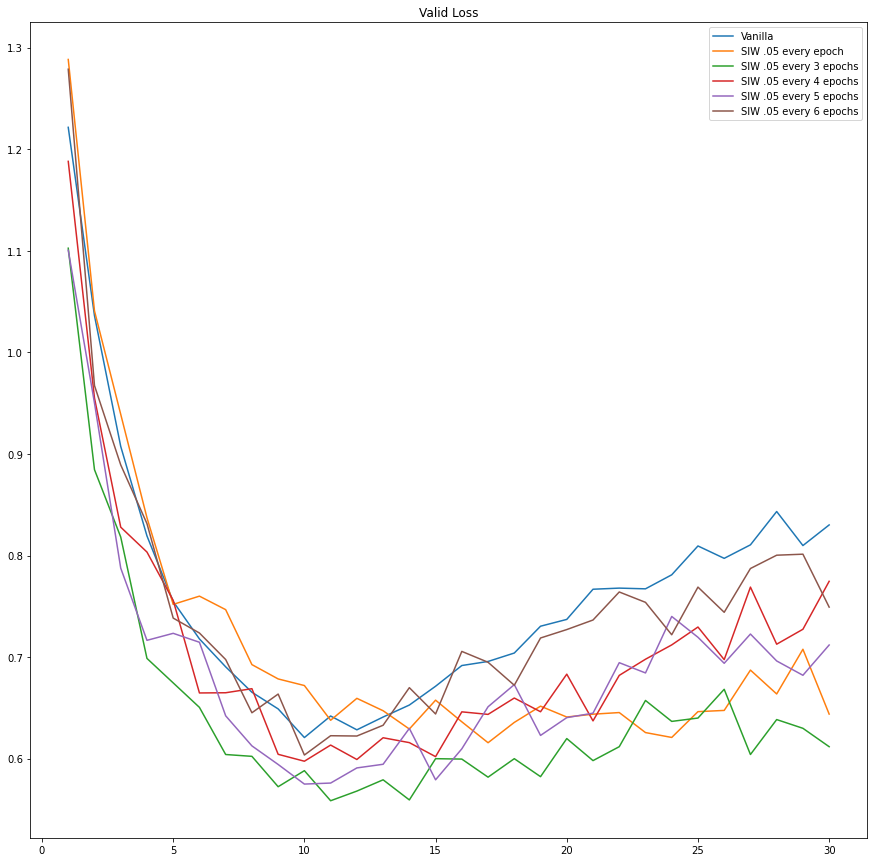

In [78]:
fig4, axs5 = plt.subplots(1)
axs5.set_title('Valid Loss')
fig4.set_figheight(15)
fig4.set_figwidth(15)
x__ = list(range(1,31))
for x in range(6):
    axs5.plot(x__, mean_results[x]['Valid_loss_mean'], label = labels2[x])
    axs5.legend()

# SIW dropout is effective at reducing and stabilizing validation loss increases after overfitting starts to occur. It
# also allows networks to reach a lower validation loss.

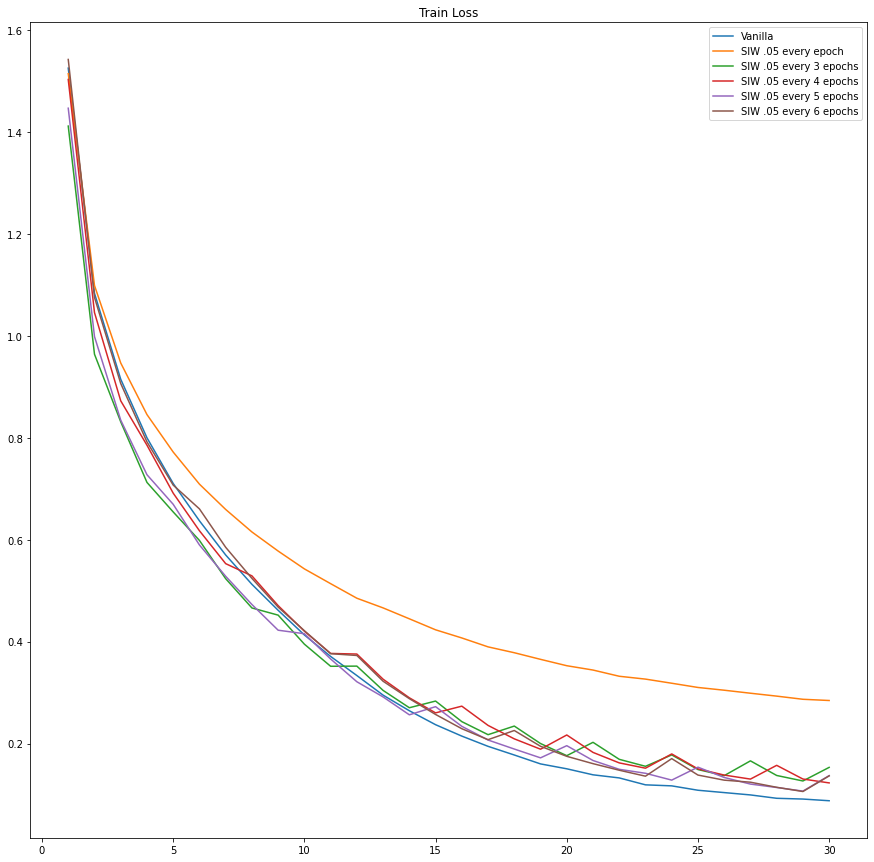

In [79]:
fig5, axs6 = plt.subplots(1)
axs6.set_title('Train Loss')
fig5.set_figheight(15)
fig5.set_figwidth(15)
for x in range(6):
    axs6.plot(x__, mean_results[x]['Train_loss_mean'], label = labels2[x])
    axs6.legend()

# SIW dropout just fractionally increases training loss in most cases (when it was not set to happen every epoch).

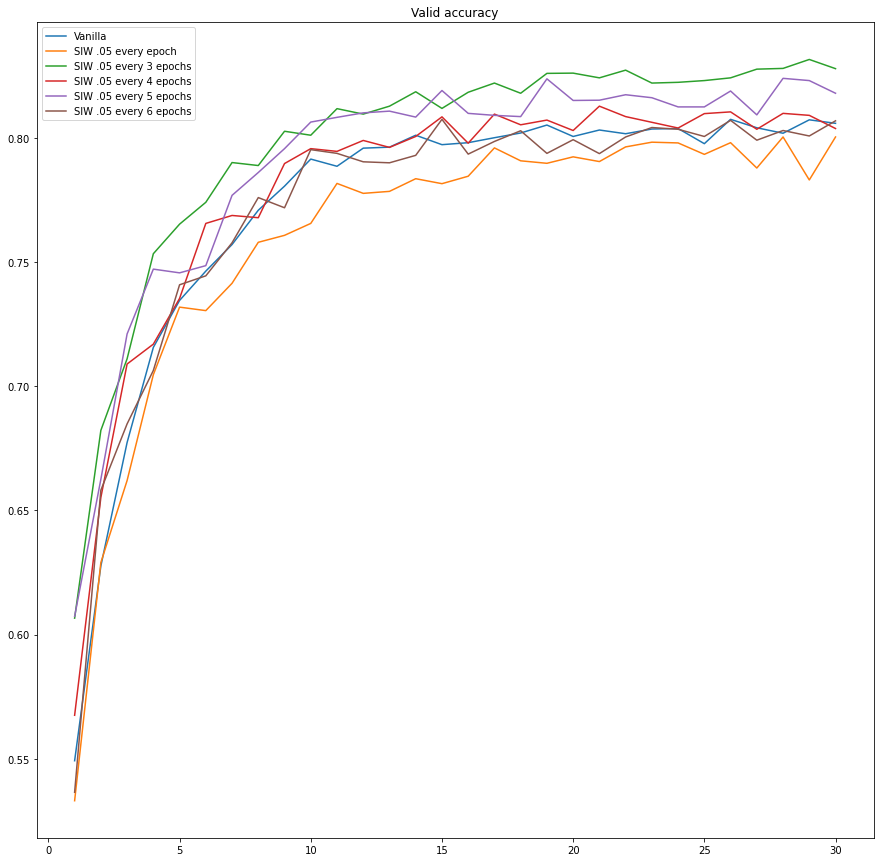

In [77]:
fig5, axs6 = plt.subplots(1)
axs6.set_title('Valid accuracy')
fig5.set_figheight(15)
fig5.set_figwidth(15)
for x in range(6):
    axs6.plot(x__, mean_results[x]['Valid_accuracy_mean'], label = labels2[x])
    axs6.legend()

# SIW dropout slightly increases validation accuracy in two cases. SIW dropout set to happen every 3 epochs with a 5%
# of probabilty seems to yield the best results. Further below 10 more vanilla networks and 10 more networks using
# SIW (p of 5% every 3 epochs) will be trained for 40 epochs to confirm results.

In [153]:
results_vanilla_FINAL = [experiment(num_epochs=40) for _ in range(10)]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 2 	Training Loss: 1.012002


Validation accuracy: 66.760% Valid loss: 0.949964



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 3 	Training Loss: 0.837947


Validation accuracy: 71.500% Valid loss: 0.813575



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.33it/s]

Epoch: 4 	Training Loss: 0.732455


Validation accuracy: 74.530% Valid loss: 0.722234



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 5 	Training Loss: 0.642703


Validation accuracy: 74.210% Valid loss: 0.736067



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 6 	Training Loss: 0.575706


Validation accuracy: 74.640% Valid loss: 0.724549



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 7 	Training Loss: 0.511602


Validation accuracy: 77.760% Valid loss: 0.657790



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1204/1563 [00:49<00:14, 24.45it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.44it/s]

Epoch: 17 	Training Loss: 0.180116


Validation accuracy: 81.510% Valid loss: 0.625917



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.25it/s]

Epoch: 18 	Training Loss: 0.160266


Validation accuracy: 81.150% Valid loss: 0.671864



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.53it/s]

Epoch: 19 	Training Loss: 0.146957


Validation accuracy: 81.300% Valid loss: 0.698790



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.42it/s]

Epoch: 20 	Training Loss: 0.134238


Validation accuracy: 81.080% Valid loss: 0.709677



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.86it/s]

Epoch: 21 	Training Loss: 0.128306


Validation accuracy: 81.380% Valid loss: 0.752122



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.29it/s]

Epoch: 23 	Training Loss: 0.113225


Validation accuracy: 80.220% Valid loss: 0.785214



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.44it/s]

Epoch: 24 	Training Loss: 0.106835


Validation accuracy: 82.110% Valid loss: 0.748694



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:19<00:00, 19.72it/s]

Epoch: 25 	Training Loss: 0.105751


Validation accuracy: 82.500% Valid loss: 0.682837



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:19<00:00, 19.64it/s]

Epoch: 26 	Training Loss: 0.095703


Validation accuracy: 81.620% Valid loss: 0.755597



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:19<00:00, 19.65it/s]

Epoch: 27 	Training Loss: 0.091220


Validation accuracy: 82.120% Valid loss: 0.752874



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.35it/s]

Epoch: 28 	Training Loss: 0.085069


Validation accuracy: 81.340% Valid loss: 0.789390



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.32it/s]

Epoch: 29 	Training Loss: 0.086424


Validation accuracy: 82.290% Valid loss: 0.740353



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:19<00:00, 19.60it/s]

Epoch: 30 	Training Loss: 0.083273


Validation accuracy: 82.390% Valid loss: 0.702088



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.11it/s]

Epoch: 31 	Training Loss: 0.076764


Validation accuracy: 80.710% Valid loss: 0.887096



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.52it/s]

Epoch: 32 	Training Loss: 0.077781


Validation accuracy: 81.840% Valid loss: 0.784484



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.39it/s]

Epoch: 33 	Training Loss: 0.070791


Validation accuracy: 82.590% Valid loss: 0.761201



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:16<00:00, 20.44it/s]

Epoch: 34 	Training Loss: 0.072962


Validation accuracy: 81.850% Valid loss: 0.813171



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.16it/s]

Epoch: 35 	Training Loss: 0.067061


Validation accuracy: 82.360% Valid loss: 0.739079



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.12it/s]

Epoch: 36 	Training Loss: 0.064358


Validation accuracy: 82.190% Valid loss: 0.807454



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.66it/s]

Epoch: 37 	Training Loss: 0.065192


Validation accuracy: 82.550% Valid loss: 0.777145



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.49it/s]

Epoch: 38 	Training Loss: 0.063985


Validation accuracy: 82.800% Valid loss: 0.786562



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.38it/s]

Epoch: 39 	Training Loss: 0.059478


Validation accuracy: 81.220% Valid loss: 0.875137



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.37it/s]

Epoch: 40 	Training Loss: 0.058949


Validation accuracy: 81.570% Valid loss: 0.786879



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.38it/s]

Epoch: 1 	Training Loss: 1.529095


Validation accuracy: 57.360% Valid loss: 1.188632



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.42it/s]

Epoch: 2 	Training Loss: 1.087925


Validation accuracy: 64.920% Valid loss: 0.973932



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.46it/s]

Epoch: 3 	Training Loss: 0.914856


Validation accuracy: 66.980% Valid loss: 0.929698



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.48it/s]

Epoch: 4 	Training Loss: 0.797925


Validation accuracy: 70.510% Valid loss: 0.823784



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.55it/s]

Epoch: 5 	Training Loss: 0.710844


Validation accuracy: 73.960% Valid loss: 0.730954



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.71it/s]

Epoch: 6 	Training Loss: 0.634557


Validation accuracy: 75.670% Valid loss: 0.682695



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.70it/s]

Epoch: 7 	Training Loss: 0.574895


Validation accuracy: 75.190% Valid loss: 0.702537



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.78it/s]

Epoch: 8 	Training Loss: 0.512653


Validation accuracy: 78.500% Valid loss: 0.615579



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.07it/s]

Epoch: 9 	Training Loss: 0.460996


Validation accuracy: 78.850% Valid loss: 0.625348



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.90it/s]

Epoch: 10 	Training Loss: 0.410861


Validation accuracy: 78.430% Valid loss: 0.651766



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.49it/s]

Epoch: 11 	Training Loss: 0.371954


Validation accuracy: 79.730% Valid loss: 0.593397



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.53it/s]

Epoch: 12 	Training Loss: 0.330343


Validation accuracy: 80.080% Valid loss: 0.615481



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:16<00:00, 20.44it/s]

Epoch: 13 	Training Loss: 0.293410


Validation accuracy: 79.680% Valid loss: 0.644912



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.38it/s]

Epoch: 14 	Training Loss: 0.258977


Validation accuracy: 80.340% Valid loss: 0.616749



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.27it/s]

Epoch: 15 	Training Loss: 0.231730


Validation accuracy: 80.580% Valid loss: 0.650656



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.66it/s]

Epoch: 16 	Training Loss: 0.204827


Validation accuracy: 80.270% Valid loss: 0.673515



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.62it/s]

Epoch: 17 	Training Loss: 0.195622


Validation accuracy: 80.150% Valid loss: 0.693117



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.94it/s]

Epoch: 18 	Training Loss: 0.169720


Validation accuracy: 79.250% Valid loss: 0.797762



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.53it/s]

Epoch: 19 	Training Loss: 0.161294


Validation accuracy: 80.830% Valid loss: 0.706988



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.77it/s]


Epoch: 20 	Training Loss: 0.142931
Validation accuracy: 80.620% Valid loss: 0.756185



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.46it/s]

Epoch: 21 	Training Loss: 0.133553


Validation accuracy: 80.620% Valid loss: 0.777984



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:11<00:00, 21.85it/s]

Epoch: 22 	Training Loss: 0.127873


Validation accuracy: 80.990% Valid loss: 0.747995



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.59it/s]

Epoch: 23 	Training Loss: 0.119858


Validation accuracy: 81.510% Valid loss: 0.711963



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.71it/s]

Epoch: 24 	Training Loss: 0.110163


Validation accuracy: 80.800% Valid loss: 0.835414



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.50it/s]

Epoch: 25 	Training Loss: 0.109920


Validation accuracy: 80.810% Valid loss: 0.759379



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.80it/s]

Epoch: 26 	Training Loss: 0.101952


Validation accuracy: 80.020% Valid loss: 0.808402



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.55it/s]

Epoch: 27 	Training Loss: 0.096739


Validation accuracy: 81.370% Valid loss: 0.787965



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.54it/s]

Epoch: 28 	Training Loss: 0.093550


Validation accuracy: 80.960% Valid loss: 0.817722



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.53it/s]

Epoch: 29 	Training Loss: 0.087362


Validation accuracy: 82.030% Valid loss: 0.811204



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 30 	Training Loss: 0.088721


Validation accuracy: 81.800% Valid loss: 0.775160



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.42it/s]

Epoch: 31 	Training Loss: 0.083602


Validation accuracy: 82.010% Valid loss: 0.781750



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.50it/s]

Epoch: 32 	Training Loss: 0.078071


Validation accuracy: 79.730% Valid loss: 0.927351



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 33 	Training Loss: 0.079594


Validation accuracy: 81.780% Valid loss: 0.818256



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.37it/s]

Epoch: 34 	Training Loss: 0.071820


Validation accuracy: 80.640% Valid loss: 0.936690



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.51it/s]

Epoch: 35 	Training Loss: 0.071382


Validation accuracy: 80.720% Valid loss: 0.842229



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.60it/s]

Epoch: 36 	Training Loss: 0.071182


Validation accuracy: 80.720% Valid loss: 0.867622



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.49it/s]

Epoch: 37 	Training Loss: 0.066065


Validation accuracy: 80.100% Valid loss: 0.919475



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.46it/s]

Epoch: 38 	Training Loss: 0.066154


Validation accuracy: 80.420% Valid loss: 0.911242



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.44it/s]

Epoch: 39 	Training Loss: 0.062765


Validation accuracy: 81.610% Valid loss: 0.878939



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 40 	Training Loss: 0.063336


Validation accuracy: 81.820% Valid loss: 0.838214



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 1 	Training Loss: 1.493734


Validation accuracy: 56.330% Valid loss: 1.219564



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.45it/s]

Epoch: 2 	Training Loss: 1.030348


Validation accuracy: 67.230% Valid loss: 0.925766



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.53it/s]

Epoch: 3 	Training Loss: 0.868641


Validation accuracy: 69.000% Valid loss: 0.849710



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.39it/s]

Epoch: 4 	Training Loss: 0.757503


Validation accuracy: 72.830% Valid loss: 0.763823



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.48it/s]

Epoch: 5 	Training Loss: 0.671647


Validation accuracy: 71.350% Valid loss: 0.831707



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.39it/s]

Epoch: 6 	Training Loss: 0.602805


Validation accuracy: 76.800% Valid loss: 0.640254



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.37it/s]

Epoch: 7 	Training Loss: 0.538021


Validation accuracy: 77.120% Valid loss: 0.653256



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.61it/s]

Epoch: 8 	Training Loss: 0.484831


Validation accuracy: 78.640% Valid loss: 0.597899



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.44it/s]

Epoch: 9 	Training Loss: 0.428701


Validation accuracy: 77.830% Valid loss: 0.664738



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.57it/s]

Epoch: 10 	Training Loss: 0.392988


Validation accuracy: 80.400% Valid loss: 0.579317



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.63it/s]

Epoch: 11 	Training Loss: 0.342332


Validation accuracy: 78.790% Valid loss: 0.625021



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.73it/s]

Epoch: 12 	Training Loss: 0.316147


Validation accuracy: 79.720% Valid loss: 0.626703



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.61it/s]

Epoch: 13 	Training Loss: 0.277680


Validation accuracy: 80.570% Valid loss: 0.611294



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.69it/s]

Epoch: 14 	Training Loss: 0.250787


Validation accuracy: 79.790% Valid loss: 0.648648



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.38it/s]

Epoch: 15 	Training Loss: 0.225246


Validation accuracy: 79.670% Valid loss: 0.649911



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.64it/s]

Epoch: 16 	Training Loss: 0.205474


Validation accuracy: 81.100% Valid loss: 0.658618



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.35it/s]

Epoch: 17 	Training Loss: 0.181848


Validation accuracy: 81.810% Valid loss: 0.637355



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.36it/s]

Epoch: 18 	Training Loss: 0.165179


Validation accuracy: 81.610% Valid loss: 0.648286



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 19 	Training Loss: 0.158069


Validation accuracy: 80.820% Valid loss: 0.704163



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 20 	Training Loss: 0.138714


Validation accuracy: 80.860% Valid loss: 0.705537



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 21 	Training Loss: 0.135888


Validation accuracy: 80.160% Valid loss: 0.742377



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 22 	Training Loss: 0.122625


Validation accuracy: 80.670% Valid loss: 0.760006



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 23 	Training Loss: 0.121650


Validation accuracy: 80.510% Valid loss: 0.719950



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.37it/s]

Epoch: 24 	Training Loss: 0.109724


Validation accuracy: 81.800% Valid loss: 0.769825



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.35it/s]

Epoch: 25 	Training Loss: 0.107455


Validation accuracy: 81.820% Valid loss: 0.688765



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 26 	Training Loss: 0.100941


Validation accuracy: 80.210% Valid loss: 0.793030



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 27 	Training Loss: 0.093390


Validation accuracy: 81.500% Valid loss: 0.756673



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 28 	Training Loss: 0.094216


Validation accuracy: 80.980% Valid loss: 0.778800



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.33it/s]

Epoch: 29 	Training Loss: 0.085292


Validation accuracy: 78.410% Valid loss: 0.961417



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.34it/s]

Epoch: 30 	Training Loss: 0.083239


Validation accuracy: 81.660% Valid loss: 0.748645



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:15<00:00, 20.80it/s]

Epoch: 31 	Training Loss: 0.081462


Validation accuracy: 81.950% Valid loss: 0.765167



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.76it/s]

Epoch: 32 	Training Loss: 0.077464


Validation accuracy: 81.510% Valid loss: 0.808360



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.18it/s]

Epoch: 33 	Training Loss: 0.073645


Validation accuracy: 81.280% Valid loss: 0.828861



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.33it/s]

Epoch: 34 	Training Loss: 0.073657


Validation accuracy: 81.490% Valid loss: 0.795495



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.37it/s]

Epoch: 35 	Training Loss: 0.073020


Validation accuracy: 82.660% Valid loss: 0.795919



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.57it/s]

Epoch: 36 	Training Loss: 0.068358


Validation accuracy: 80.350% Valid loss: 0.822057



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.45it/s]

Epoch: 37 	Training Loss: 0.062953


Validation accuracy: 81.380% Valid loss: 0.863791



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.34it/s]

Epoch: 38 	Training Loss: 0.067088


Validation accuracy: 81.760% Valid loss: 0.810526



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.16it/s]

Epoch: 40 	Training Loss: 0.062839


Validation accuracy: 81.300% Valid loss: 0.866445



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.58it/s]

Epoch: 1 	Training Loss: 1.631197


Validation accuracy: 52.700% Valid loss: 1.359155



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.71it/s]

Epoch: 2 	Training Loss: 1.148272


Validation accuracy: 63.350% Valid loss: 1.028305



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.59it/s]

Epoch: 3 	Training Loss: 0.956158


Validation accuracy: 68.810% Valid loss: 0.886326



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.76it/s]

Epoch: 4 	Training Loss: 0.827547


Validation accuracy: 70.300% Valid loss: 0.848380



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.40it/s]

Epoch: 5 	Training Loss: 0.734208


Validation accuracy: 74.140% Valid loss: 0.738249



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1313/1563 [00:53<00:10, 24.49it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.33it/s]

Epoch: 13 	Training Loss: 0.303513


Validation accuracy: 78.250% Valid loss: 0.678942



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.35it/s]

Epoch: 14 	Training Loss: 0.269723


Validation accuracy: 79.020% Valid loss: 0.674449



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.42it/s]

Epoch: 15 	Training Loss: 0.237926


Validation accuracy: 80.360% Valid loss: 0.661737



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.41it/s]

Epoch: 16 	Training Loss: 0.214103


Validation accuracy: 80.950% Valid loss: 0.655151



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 17 	Training Loss: 0.198519


Validation accuracy: 79.290% Valid loss: 0.735739



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.38it/s]

Epoch: 18 	Training Loss: 0.173723


Validation accuracy: 80.970% Valid loss: 0.685912



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.48it/s]

Epoch: 19 	Training Loss: 0.161013


Validation accuracy: 79.720% Valid loss: 0.765826



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 20 	Training Loss: 0.153026


Validation accuracy: 79.760% Valid loss: 0.764804



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.43it/s]

Epoch: 21 	Training Loss: 0.137758


Validation accuracy: 79.760% Valid loss: 0.782382



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.46it/s]

Epoch: 23 	Training Loss: 0.125045


Validation accuracy: 79.500% Valid loss: 0.817511



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.40it/s]

Epoch: 24 	Training Loss: 0.112300


Validation accuracy: 79.440% Valid loss: 0.846187



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.48it/s]

Epoch: 25 	Training Loss: 0.108382


Validation accuracy: 80.430% Valid loss: 0.757269



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.40it/s]

Epoch: 26 	Training Loss: 0.108559


Validation accuracy: 81.150% Valid loss: 0.760405



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.37it/s]

Epoch: 27 	Training Loss: 0.097640


Validation accuracy: 80.560% Valid loss: 0.822824



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 28 	Training Loss: 0.092285


Validation accuracy: 80.200% Valid loss: 0.823877



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1556/1563 [01:03<00:00, 24.38it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.41it/s]

Epoch: 35 	Training Loss: 0.073005



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.53it/s]

Epoch: 37 	Training Loss: 0.071813


Validation accuracy: 80.330% Valid loss: 0.899645



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 38 	Training Loss: 0.067842


Validation accuracy: 80.300% Valid loss: 0.863318



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.71it/s]

Epoch: 39 	Training Loss: 0.063047


Validation accuracy: 80.640% Valid loss: 0.892232



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.40it/s]

Epoch: 40 	Training Loss: 0.064850


Validation accuracy: 80.190% Valid loss: 0.915907



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.45it/s]

Epoch: 1 	Training Loss: 1.756425


Validation accuracy: 49.380% Valid loss: 1.377224



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1087/1563 [00:59<00:24, 19.69it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 8 	Training Loss: 0.595973


Validation accuracy: 74.740% Valid loss: 0.721746



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.42it/s]

Epoch: 9 	Training Loss: 0.539950


Validation accuracy: 75.870% Valid loss: 0.710122



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.64it/s]

Epoch: 10 	Training Loss: 0.480779


Validation accuracy: 75.260% Valid loss: 0.727952



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.65it/s]

Epoch: 11 	Training Loss: 0.434723


Validation accuracy: 77.250% Valid loss: 0.671333



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 14 	Training Loss: 0.312023


Validation accuracy: 77.790% Valid loss: 0.724326



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 15 	Training Loss: 0.275488


Validation accuracy: 77.100% Valid loss: 0.766437



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 16 	Training Loss: 0.245625


Validation accuracy: 76.050% Valid loss: 0.845649



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 19 	Training Loss: 0.182002


Validation accuracy: 78.020% Valid loss: 0.811465



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 20 	Training Loss: 0.167757


Validation accuracy: 76.240% Valid loss: 0.972404



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 21 	Training Loss: 0.157527


Validation accuracy: 77.780% Valid loss: 0.852490



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 22 	Training Loss: 0.141313


Validation accuracy: 77.070% Valid loss: 0.958962



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 23 	Training Loss: 0.137201


Validation accuracy: 78.340% Valid loss: 0.891159



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]

Epoch: 24 	Training Loss: 0.128669


Validation accuracy: 77.580% Valid loss: 0.969099



 35%|█████████████████████████████████████████████████████████                                                                                                           | 544/1563 [00:22<00:42, 24.25it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 30 	Training Loss: 0.092044


Validation accuracy: 78.940% Valid loss: 0.953161



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.22it/s]

Epoch: 33 	Training Loss: 0.086293


Validation accuracy: 78.070% Valid loss: 0.984792



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 34 	Training Loss: 0.077163


Validation accuracy: 77.510% Valid loss: 1.090103



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 35 	Training Loss: 0.080313


Validation accuracy: 78.280% Valid loss: 1.043160



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 36 	Training Loss: 0.075610


Validation accuracy: 76.670% Valid loss: 1.080580



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.16it/s]

Epoch: 37 	Training Loss: 0.073716


Validation accuracy: 78.450% Valid loss: 1.064122



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]

Epoch: 38 	Training Loss: 0.070591


Validation accuracy: 78.780% Valid loss: 1.026234



 43%|█████████████████████████████████████████████████████████████████████▉                                                                                              | 667/1563 [00:27<00:36, 24.37it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 29 	Training Loss: 0.086317


Validation accuracy: 81.280% Valid loss: 0.773717



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 30 	Training Loss: 0.083473


Validation accuracy: 81.560% Valid loss: 0.752823



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 31 	Training Loss: 0.079303


Validation accuracy: 81.420% Valid loss: 0.818409



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 32 	Training Loss: 0.075672


Validation accuracy: 80.980% Valid loss: 0.838760



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 33 	Training Loss: 0.080109


Validation accuracy: 81.220% Valid loss: 0.752425



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]

Epoch: 34 	Training Loss: 0.068735


Validation accuracy: 82.310% Valid loss: 0.830027



 45%|█████████████████████████████████████████████████████████████████████████▍                                                                                          | 700/1563 [00:28<00:35, 24.36it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 35 	Training Loss: 0.071274


Validation accuracy: 80.390% Valid loss: 0.893567



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]

Epoch: 36 	Training Loss: 0.066427


Validation accuracy: 81.230% Valid loss: 0.819943



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 37 	Training Loss: 0.066676


Validation accuracy: 81.760% Valid loss: 0.829354



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 38 	Training Loss: 0.062350


Validation accuracy: 81.480% Valid loss: 0.874845



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 39 	Training Loss: 0.064586


Validation accuracy: 81.500% Valid loss: 0.833737



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 40 	Training Loss: 0.059508


Validation accuracy: 80.150% Valid loss: 0.900294



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 1 	Training Loss: 1.376082


Validation accuracy: 62.620% Valid loss: 1.057589



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 2 	Training Loss: 0.962757


Validation accuracy: 68.250% Valid loss: 0.884385



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 3 	Training Loss: 0.796809


Validation accuracy: 71.680% Valid loss: 0.799409



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 4 	Training Loss: 0.693560


Validation accuracy: 74.670% Valid loss: 0.727815



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.20it/s]

Epoch: 5 	Training Loss: 0.605107


Validation accuracy: 76.200% Valid loss: 0.696817



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 6 	Training Loss: 0.543012


Validation accuracy: 80.240% Valid loss: 0.565913



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 7 	Training Loss: 0.482050


Validation accuracy: 80.110% Valid loss: 0.585198



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 8 	Training Loss: 0.428964


Validation accuracy: 81.340% Valid loss: 0.538844



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 9 	Training Loss: 0.381106


Validation accuracy: 81.010% Valid loss: 0.562290



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 10 	Training Loss: 0.340910


Validation accuracy: 81.280% Valid loss: 0.538593



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 11 	Training Loss: 0.304622


Validation accuracy: 81.850% Valid loss: 0.528133



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 12 	Training Loss: 0.269742


Validation accuracy: 81.350% Valid loss: 0.574533



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 13 	Training Loss: 0.241953


Validation accuracy: 82.680% Valid loss: 0.566382



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 14 	Training Loss: 0.215482


Validation accuracy: 83.090% Valid loss: 0.562059



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 15 	Training Loss: 0.195736


Validation accuracy: 80.770% Valid loss: 0.634101



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 16 	Training Loss: 0.181952


Validation accuracy: 82.640% Valid loss: 0.589854



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 17 	Training Loss: 0.158273


Validation accuracy: 82.830% Valid loss: 0.596259



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 18 	Training Loss: 0.145306


Validation accuracy: 82.550% Valid loss: 0.639138



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.36it/s]

Epoch: 19 	Training Loss: 0.140162


Validation accuracy: 83.260% Valid loss: 0.602994



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 20 	Training Loss: 0.126103


Validation accuracy: 82.330% Valid loss: 0.637174



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 21 	Training Loss: 0.117629


Validation accuracy: 82.410% Valid loss: 0.725354



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 22 	Training Loss: 0.113924


Validation accuracy: 83.100% Valid loss: 0.639348



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 23 	Training Loss: 0.104730


Validation accuracy: 82.330% Valid loss: 0.688466



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 24 	Training Loss: 0.101454


Validation accuracy: 83.450% Valid loss: 0.682004



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.39it/s]

Epoch: 25 	Training Loss: 0.094657


Validation accuracy: 83.290% Valid loss: 0.643613



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 26 	Training Loss: 0.092835


Validation accuracy: 82.400% Valid loss: 0.690881



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 27 	Training Loss: 0.088986


Validation accuracy: 83.670% Valid loss: 0.667115



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 29 	Training Loss: 0.079060


Validation accuracy: 83.160% Valid loss: 0.704008



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 31 	Training Loss: 0.074972


Validation accuracy: 82.690% Valid loss: 0.753585



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.38it/s]

Epoch: 32 	Training Loss: 0.068737


Validation accuracy: 83.730% Valid loss: 0.695817



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.40it/s]

Epoch: 33 	Training Loss: 0.069774


Validation accuracy: 82.360% Valid loss: 0.764361



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.37it/s]

Epoch: 34 	Training Loss: 0.065868


Validation accuracy: 84.700% Valid loss: 0.672442



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.38it/s]

Epoch: 35 	Training Loss: 0.062297


Validation accuracy: 84.150% Valid loss: 0.745877



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.48it/s]

Epoch: 36 	Training Loss: 0.066271


Validation accuracy: 83.700% Valid loss: 0.672004



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1150/1563 [00:46<00:16, 24.64it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.69it/s]

Epoch: 9 	Training Loss: 0.544448


Validation accuracy: 75.200% Valid loss: 0.722560



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.40it/s]

Epoch: 10 	Training Loss: 0.494499


Validation accuracy: 76.000% Valid loss: 0.706869



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.39it/s]

Epoch: 11 	Training Loss: 0.446355


Validation accuracy: 75.310% Valid loss: 0.735308



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.48it/s]

Epoch: 12 	Training Loss: 0.398006


Validation accuracy: 76.640% Valid loss: 0.704578



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.49it/s]

Epoch: 13 	Training Loss: 0.350207


Validation accuracy: 75.480% Valid loss: 0.765149



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 14 	Training Loss: 0.315900


Validation accuracy: 76.560% Valid loss: 0.742059



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 15 	Training Loss: 0.280158


Validation accuracy: 76.670% Valid loss: 0.789244



 31%|██████████████████████████████████████████████████▊                                                                                                                 | 484/1563 [00:19<00:43, 24.85it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.37it/s]

Epoch: 25 	Training Loss: 0.124034


Validation accuracy: 77.390% Valid loss: 0.916829



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.22it/s]

Epoch: 26 	Training Loss: 0.110819


Validation accuracy: 76.940% Valid loss: 0.965026



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.04it/s]

Epoch: 27 	Training Loss: 0.110138


Validation accuracy: 77.000% Valid loss: 0.954141



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.15it/s]

Epoch: 28 	Training Loss: 0.106728


Validation accuracy: 77.770% Valid loss: 0.929229



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.27it/s]

Epoch: 29 	Training Loss: 0.104283


Validation accuracy: 76.050% Valid loss: 1.057639



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.39it/s]

Epoch: 30 	Training Loss: 0.094629


Validation accuracy: 77.660% Valid loss: 0.954794



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.40it/s]

Epoch: 31 	Training Loss: 0.091655


Validation accuracy: 78.940% Valid loss: 0.957453



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.51it/s]

Epoch: 32 	Training Loss: 0.089665


Validation accuracy: 77.790% Valid loss: 0.953307



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 33 	Training Loss: 0.082022


Validation accuracy: 76.710% Valid loss: 1.089684



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 34 	Training Loss: 0.082965


Validation accuracy: 76.890% Valid loss: 1.097479



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 35 	Training Loss: 0.082091


Validation accuracy: 78.320% Valid loss: 1.009412



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.33it/s]

Epoch: 36 	Training Loss: 0.077078


Validation accuracy: 78.260% Valid loss: 1.107650



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 37 	Training Loss: 0.074950


Validation accuracy: 78.280% Valid loss: 1.044573



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 39 	Training Loss: 0.072701


Validation accuracy: 77.940% Valid loss: 1.036868



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.61it/s]

Epoch: 40 	Training Loss: 0.068325


Validation accuracy: 78.590% Valid loss: 1.039082



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 1 	Training Loss: 1.412158


Validation accuracy: 61.520% Valid loss: 1.051038



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.81it/s]

Epoch: 2 	Training Loss: 0.979698


Validation accuracy: 66.810% Valid loss: 0.943379



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.76it/s]

Epoch: 3 	Training Loss: 0.817427


Validation accuracy: 74.050% Valid loss: 0.738420



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.78it/s]

Epoch: 4 	Training Loss: 0.714626


Validation accuracy: 75.200% Valid loss: 0.692998



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.81it/s]

Epoch: 5 	Training Loss: 0.625903


Validation accuracy: 75.520% Valid loss: 0.714253



  3%|█████▏                                                                                                                                                               | 49/1563 [00:02<01:01, 24.82it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.59it/s]

Epoch: 9 	Training Loss: 0.397832


Validation accuracy: 78.800% Valid loss: 0.628313



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.58it/s]

Epoch: 11 	Training Loss: 0.318424



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.60it/s]

Epoch: 13 	Training Loss: 0.251657


Validation accuracy: 81.540% Valid loss: 0.573812



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.56it/s]

Epoch: 14 	Training Loss: 0.225676


Validation accuracy: 81.840% Valid loss: 0.577988



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 15 	Training Loss: 0.204977


Validation accuracy: 82.470% Valid loss: 0.582671



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.36it/s]

Epoch: 16 	Training Loss: 0.184401


Validation accuracy: 82.800% Valid loss: 0.586802



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.45it/s]

Epoch: 17 	Training Loss: 0.168837


Validation accuracy: 81.620% Valid loss: 0.626522



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.43it/s]

Epoch: 18 	Training Loss: 0.154087


Validation accuracy: 81.940% Valid loss: 0.656604



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1027/1563 [00:41<00:21, 24.60it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.49it/s]

Epoch: 30 	Training Loss: 0.076730


Validation accuracy: 83.030% Valid loss: 0.719810



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.46it/s]

Epoch: 31 	Training Loss: 0.075460


Validation accuracy: 83.550% Valid loss: 0.687945



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.37it/s]

Epoch: 32 	Training Loss: 0.073177


Validation accuracy: 82.750% Valid loss: 0.730266



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 33 	Training Loss: 0.069909


Validation accuracy: 83.600% Valid loss: 0.740349



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 34 	Training Loss: 0.072202


Validation accuracy: 82.770% Valid loss: 0.709397



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.05it/s]

Epoch: 35 	Training Loss: 0.064448


Validation accuracy: 83.480% Valid loss: 0.725851



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:05<00:00, 23.77it/s]

Epoch: 36 	Training Loss: 0.063883


Validation accuracy: 84.000% Valid loss: 0.717879



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 37 	Training Loss: 0.060706


Validation accuracy: 83.560% Valid loss: 0.745818



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:11<00:00, 21.93it/s]

Epoch: 38 	Training Loss: 0.061949


Validation accuracy: 83.300% Valid loss: 0.775417



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.07it/s]

Epoch: 39 	Training Loss: 0.062114


Validation accuracy: 83.380% Valid loss: 0.727562



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.16it/s]

Epoch: 40 	Training Loss: 0.055443


Validation accuracy: 83.520% Valid loss: 0.700784



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.10it/s]

Epoch: 1 	Training Loss: 1.556250


Validation accuracy: 55.640% Valid loss: 1.215121



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.04it/s]

Epoch: 2 	Training Loss: 1.085120


Validation accuracy: 65.680% Valid loss: 0.952185



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.23it/s]

Epoch: 3 	Training Loss: 0.922355


Validation accuracy: 68.340% Valid loss: 0.875545



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:28<00:00, 17.68it/s]

Epoch: 4 	Training Loss: 0.799305


Validation accuracy: 72.590% Valid loss: 0.793688



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.30it/s]

Epoch: 5 	Training Loss: 0.718753


Validation accuracy: 73.140% Valid loss: 0.772833



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.26it/s]

Epoch: 6 	Training Loss: 0.646169


Validation accuracy: 74.320% Valid loss: 0.727734



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.41it/s]

Epoch: 7 	Training Loss: 0.585115


Validation accuracy: 74.560% Valid loss: 0.710462



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.18it/s]

Epoch: 8 	Training Loss: 0.523913


Validation accuracy: 76.620% Valid loss: 0.677106



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.06it/s]

Epoch: 9 	Training Loss: 0.473441


Validation accuracy: 77.080% Valid loss: 0.678007



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.12it/s]

Epoch: 10 	Training Loss: 0.424627


Validation accuracy: 78.830% Valid loss: 0.627603



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.55it/s]

Epoch: 11 	Training Loss: 0.380260


Validation accuracy: 78.190% Valid loss: 0.629847



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 12 	Training Loss: 0.343671


Validation accuracy: 77.880% Valid loss: 0.680266



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.66it/s]

Epoch: 13 	Training Loss: 0.306933


Validation accuracy: 79.150% Valid loss: 0.637143



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 14 	Training Loss: 0.275124


Validation accuracy: 79.650% Valid loss: 0.645934



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 15 	Training Loss: 0.240905


Validation accuracy: 79.020% Valid loss: 0.702204



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 16 	Training Loss: 0.222826


Validation accuracy: 80.040% Valid loss: 0.709946



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 17 	Training Loss: 0.201597


Validation accuracy: 79.650% Valid loss: 0.693032



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 18 	Training Loss: 0.181557


Validation accuracy: 79.110% Valid loss: 0.748241



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 19 	Training Loss: 0.169269


Validation accuracy: 80.030% Valid loss: 0.705496



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 20 	Training Loss: 0.153378


Validation accuracy: 80.420% Valid loss: 0.719980



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 21 	Training Loss: 0.138899


Validation accuracy: 80.630% Valid loss: 0.748138



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 22 	Training Loss: 0.136275


Validation accuracy: 81.070% Valid loss: 0.747256



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 23 	Training Loss: 0.123968


Validation accuracy: 80.600% Valid loss: 0.726005



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 24 	Training Loss: 0.117005


Validation accuracy: 78.960% Valid loss: 0.860903



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 25 	Training Loss: 0.114267


Validation accuracy: 80.010% Valid loss: 0.843430



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 26 	Training Loss: 0.110340


Validation accuracy: 80.030% Valid loss: 0.803407



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 27 	Training Loss: 0.101454


Validation accuracy: 80.480% Valid loss: 0.837074



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 28 	Training Loss: 0.099421


Validation accuracy: 80.660% Valid loss: 0.803815



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 29 	Training Loss: 0.091597


Validation accuracy: 81.230% Valid loss: 0.776057



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 30 	Training Loss: 0.088571


Validation accuracy: 81.150% Valid loss: 0.841486



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 31 	Training Loss: 0.088457


Validation accuracy: 81.550% Valid loss: 0.768246



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 32 	Training Loss: 0.084924


Validation accuracy: 80.990% Valid loss: 0.825277



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 33 	Training Loss: 0.076859


Validation accuracy: 81.220% Valid loss: 0.780545



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 34 	Training Loss: 0.076265


Validation accuracy: 80.720% Valid loss: 0.842550



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 35 	Training Loss: 0.074973


Validation accuracy: 79.250% Valid loss: 0.940341



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.46it/s]

Epoch: 36 	Training Loss: 0.069231


Validation accuracy: 81.050% Valid loss: 0.853487



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 37 	Training Loss: 0.068409


Validation accuracy: 81.100% Valid loss: 0.882705



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.55it/s]

Epoch: 38 	Training Loss: 0.066908


Validation accuracy: 80.920% Valid loss: 0.854835



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.27it/s]

Epoch: 39 	Training Loss: 0.067784


Validation accuracy: 80.880% Valid loss: 0.886797



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.25it/s]


Epoch: 40 	Training Loss: 0.062546
Validation accuracy: 80.870% Valid loss: 0.867815

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.16it/s]

Epoch: 1 	Training Loss: 1.509515


Validation accuracy: 56.310% Valid loss: 1.204098

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.32it/s]

Epoch: 2 	Training Loss: 1.052855


Validation accuracy: 64.610% Valid loss: 0.973060

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.19it/s]

Epoch: 3 	Training Loss: 0.893055


Validation accuracy: 71.340% Valid loss: 0.815523

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.30it/s]

Epoch: 4 	Training Loss: 0.778056


Validation accuracy: 72.860% Valid loss: 0.768218

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.18it/s]

Epoch: 5 	Training Loss: 0.690716


Validation accuracy: 74.240% Valid loss: 0.725168

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.24it/s]

Epoch: 6 	Training Loss: 0.616007


Validation accuracy: 77.730% Valid loss: 0.624419

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:17<00:00, 20.05it/s]

Epoch: 7 	Training Loss: 0.547237


Validation accuracy: 75.770% Valid loss: 0.668765

Performing boston dropout...


 37%|███████████████████████████████████████████████████████████▉                                                                                                        | 571/1563 [00:23<00:41, 24.16it/s]


KeyboardInterrupt: 

In [249]:
results_vanilla_FINAL_mean = dict_mean(results_vanilla_FINAL)

In [185]:
results_SIW_05_every3epoch_FINAL = [experiment(.05, 3, 40) for _ in range(10)]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.75it/s]

Epoch: 1 	Training Loss: 1.467590


Validation accuracy: 55.230% Valid loss: 1.228628



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.10it/s]

Epoch: 2 	Training Loss: 1.001063


Validation accuracy: 68.780% Valid loss: 0.896907

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.74it/s]

Epoch: 3 	Training Loss: 0.853874


Validation accuracy: 72.890% Valid loss: 0.770166



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.76it/s]

Epoch: 4 	Training Loss: 0.736371


Validation accuracy: 74.460% Valid loss: 0.728638



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.76it/s]

Epoch: 5 	Training Loss: 0.646233


Validation accuracy: 75.430% Valid loss: 0.698792

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.64it/s]

Epoch: 6 	Training Loss: 0.608989


Validation accuracy: 76.140% Valid loss: 0.676750



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.68it/s]

Epoch: 7 	Training Loss: 0.537891


Validation accuracy: 79.020% Valid loss: 0.602115



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.69it/s]

Epoch: 8 	Training Loss: 0.485054


Validation accuracy: 78.560% Valid loss: 0.610466

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 19.00it/s]

Epoch: 9 	Training Loss: 0.466202


Validation accuracy: 80.160% Valid loss: 0.582442



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.76it/s]

Epoch: 10 	Training Loss: 0.404405


Validation accuracy: 80.110% Valid loss: 0.579622



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.74it/s]

Epoch: 11 	Training Loss: 0.366246


Validation accuracy: 80.180% Valid loss: 0.588285

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.82it/s]

Epoch: 12 	Training Loss: 0.365740


Validation accuracy: 81.000% Valid loss: 0.562083



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.70it/s]

Epoch: 13 	Training Loss: 0.316575


Validation accuracy: 79.470% Valid loss: 0.634929



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.80it/s]

Epoch: 14 	Training Loss: 0.282757


Validation accuracy: 81.530% Valid loss: 0.573007

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.73it/s]

Epoch: 15 	Training Loss: 0.296171


Validation accuracy: 80.800% Valid loss: 0.593504



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.59it/s]

Epoch: 16 	Training Loss: 0.251384


Validation accuracy: 81.470% Valid loss: 0.573373



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.88it/s]

Epoch: 17 	Training Loss: 0.223585


Validation accuracy: 80.760% Valid loss: 0.620558

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.74it/s]

Epoch: 18 	Training Loss: 0.240934


Validation accuracy: 82.240% Valid loss: 0.589349



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.86it/s]

Epoch: 19 	Training Loss: 0.204107


Validation accuracy: 81.890% Valid loss: 0.612935



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.84it/s]

Epoch: 20 	Training Loss: 0.187469


Validation accuracy: 80.970% Valid loss: 0.663347

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.83it/s]

Epoch: 21 	Training Loss: 0.209510


Validation accuracy: 81.510% Valid loss: 0.646582



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 19.00it/s]

Epoch: 22 	Training Loss: 0.177180


Validation accuracy: 82.220% Valid loss: 0.621283



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 19.04it/s]

Epoch: 23 	Training Loss: 0.156987


Validation accuracy: 81.920% Valid loss: 0.646258

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.96it/s]

Epoch: 24 	Training Loss: 0.181717


Validation accuracy: 80.500% Valid loss: 0.685205



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 19.05it/s]

Epoch: 25 	Training Loss: 0.154061


Validation accuracy: 81.490% Valid loss: 0.649032



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.94it/s]

Epoch: 26 	Training Loss: 0.143592


Validation accuracy: 82.210% Valid loss: 0.636218

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.92it/s]

Epoch: 27 	Training Loss: 0.168170


Validation accuracy: 81.170% Valid loss: 0.675940



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.06it/s]

Epoch: 28 	Training Loss: 0.141509


Validation accuracy: 81.970% Valid loss: 0.624001



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.95it/s]


Epoch: 29 	Training Loss: 0.131987
Validation accuracy: 81.780% Valid loss: 0.708584

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.31it/s]

Epoch: 30 	Training Loss: 0.154481


Validation accuracy: 82.250% Valid loss: 0.676603



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.35it/s]

Epoch: 31 	Training Loss: 0.129659


Validation accuracy: 81.190% Valid loss: 0.673534



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.36it/s]

Epoch: 32 	Training Loss: 0.118348


Validation accuracy: 80.830% Valid loss: 0.713108

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.30it/s]

Epoch: 33 	Training Loss: 0.154721


Validation accuracy: 82.730% Valid loss: 0.627408



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.29it/s]

Epoch: 34 	Training Loss: 0.118483


Validation accuracy: 82.110% Valid loss: 0.674887



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.30it/s]

Epoch: 35 	Training Loss: 0.110946


Validation accuracy: 81.200% Valid loss: 0.757108

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.92it/s]

Epoch: 36 	Training Loss: 0.140134


Validation accuracy: 81.790% Valid loss: 0.695671



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.67it/s]

Epoch: 37 	Training Loss: 0.112818


Validation accuracy: 81.890% Valid loss: 0.679333



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.22it/s]

Epoch: 38 	Training Loss: 0.109083


Validation accuracy: 83.080% Valid loss: 0.672624

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 39 	Training Loss: 0.134849


Validation accuracy: 82.620% Valid loss: 0.661708



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 40 	Training Loss: 0.107436


Validation accuracy: 82.680% Valid loss: 0.667390



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 1 	Training Loss: 1.496394


Validation accuracy: 58.960% Valid loss: 1.126924



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 2 	Training Loss: 1.028831


Validation accuracy: 61.030% Valid loss: 1.053567

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 3 	Training Loss: 0.879922


Validation accuracy: 70.680% Valid loss: 0.825036



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 4 	Training Loss: 0.756316


Validation accuracy: 71.100% Valid loss: 0.809012



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 5 	Training Loss: 0.661597


Validation accuracy: 74.410% Valid loss: 0.726361

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 6 	Training Loss: 0.623629


Validation accuracy: 76.910% Valid loss: 0.655230



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 7 	Training Loss: 0.550015


Validation accuracy: 77.180% Valid loss: 0.679924



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 8 	Training Loss: 0.489682


Validation accuracy: 78.770% Valid loss: 0.617416

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.22it/s]

Epoch: 9 	Training Loss: 0.476504


Validation accuracy: 76.190% Valid loss: 0.705740



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 10 	Training Loss: 0.416813


Validation accuracy: 80.200% Valid loss: 0.590241



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 11 	Training Loss: 0.372570


Validation accuracy: 78.770% Valid loss: 0.662887

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 12 	Training Loss: 0.371706


Validation accuracy: 80.930% Valid loss: 0.573664



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 13 	Training Loss: 0.321344


Validation accuracy: 77.610% Valid loss: 0.679493



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 14 	Training Loss: 0.287698


Validation accuracy: 80.670% Valid loss: 0.613407

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 15 	Training Loss: 0.298309


Validation accuracy: 80.390% Valid loss: 0.612642



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 16 	Training Loss: 0.256582


Validation accuracy: 82.180% Valid loss: 0.577183



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.36it/s]

Epoch: 17 	Training Loss: 0.226066


Validation accuracy: 81.320% Valid loss: 0.613315

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 18 	Training Loss: 0.247498


Validation accuracy: 81.090% Valid loss: 0.626401



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 19 	Training Loss: 0.210686


Validation accuracy: 81.160% Valid loss: 0.651698



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 20 	Training Loss: 0.185853


Validation accuracy: 82.300% Valid loss: 0.637809

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.20it/s]

Epoch: 21 	Training Loss: 0.208966


Validation accuracy: 81.310% Valid loss: 0.673704



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 22 	Training Loss: 0.179795


Validation accuracy: 80.470% Valid loss: 0.655738



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 23 	Training Loss: 0.161774


Validation accuracy: 80.130% Valid loss: 0.699766

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 24 	Training Loss: 0.184754


Validation accuracy: 80.590% Valid loss: 0.734148



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 25 	Training Loss: 0.158510


Validation accuracy: 81.900% Valid loss: 0.644470



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 26 	Training Loss: 0.140366


Validation accuracy: 79.970% Valid loss: 0.760066

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 27 	Training Loss: 0.168359


Validation accuracy: 81.850% Valid loss: 0.644907



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 28 	Training Loss: 0.142675


Validation accuracy: 80.980% Valid loss: 0.677765



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.34it/s]

Epoch: 29 	Training Loss: 0.132817


Validation accuracy: 80.950% Valid loss: 0.715097

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 30 	Training Loss: 0.156236


Validation accuracy: 79.810% Valid loss: 0.785872



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 31 	Training Loss: 0.134148


Validation accuracy: 80.510% Valid loss: 0.706264



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 32 	Training Loss: 0.118517


Validation accuracy: 81.660% Valid loss: 0.761601

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 33 	Training Loss: 0.151694


Validation accuracy: 80.900% Valid loss: 0.701214



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 34 	Training Loss: 0.123737


Validation accuracy: 82.270% Valid loss: 0.693511



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 35 	Training Loss: 0.109604


Validation accuracy: 82.190% Valid loss: 0.704782

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 36 	Training Loss: 0.147697


Validation accuracy: 82.520% Valid loss: 0.662605



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 37 	Training Loss: 0.117081


Validation accuracy: 82.120% Valid loss: 0.699832



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 38 	Training Loss: 0.106665


Validation accuracy: 80.750% Valid loss: 0.775183

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 39 	Training Loss: 0.140823


Validation accuracy: 81.770% Valid loss: 0.728423



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 40 	Training Loss: 0.110478


Validation accuracy: 82.040% Valid loss: 0.716413



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 1 	Training Loss: 1.418852


Validation accuracy: 56.440% Valid loss: 1.246590



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 2 	Training Loss: 0.980636


Validation accuracy: 66.000% Valid loss: 0.933617

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 3 	Training Loss: 0.842005


Validation accuracy: 71.770% Valid loss: 0.806196



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.33it/s]

Epoch: 4 	Training Loss: 0.725242


Validation accuracy: 70.740% Valid loss: 0.824291



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 5 	Training Loss: 0.634915


Validation accuracy: 76.810% Valid loss: 0.659753

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 6 	Training Loss: 0.597653


Validation accuracy: 74.510% Valid loss: 0.717373



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 7 	Training Loss: 0.539230


Validation accuracy: 79.660% Valid loss: 0.582309



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 8 	Training Loss: 0.473065


Validation accuracy: 78.020% Valid loss: 0.625190

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 9 	Training Loss: 0.455652


Validation accuracy: 79.370% Valid loss: 0.596968



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 10 	Training Loss: 0.399105


Validation accuracy: 80.840% Valid loss: 0.551549



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 11 	Training Loss: 0.358168


Validation accuracy: 81.510% Valid loss: 0.563662

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]

Epoch: 12 	Training Loss: 0.355221


Validation accuracy: 82.570% Valid loss: 0.527852



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 13 	Training Loss: 0.312153


Validation accuracy: 81.160% Valid loss: 0.582281



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 14 	Training Loss: 0.275538


Validation accuracy: 82.510% Valid loss: 0.580513

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 15 	Training Loss: 0.285665


Validation accuracy: 80.150% Valid loss: 0.600026



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 16 	Training Loss: 0.246637


Validation accuracy: 80.070% Valid loss: 0.612464



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 17 	Training Loss: 0.226126


Validation accuracy: 81.590% Valid loss: 0.597035

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 18 	Training Loss: 0.239772


Validation accuracy: 82.250% Valid loss: 0.574517



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 19 	Training Loss: 0.207525


Validation accuracy: 81.530% Valid loss: 0.631617



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.38it/s]

Epoch: 20 	Training Loss: 0.181391


Validation accuracy: 81.920% Valid loss: 0.628189

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 21 	Training Loss: 0.209508


Validation accuracy: 81.270% Valid loss: 0.674585



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 22 	Training Loss: 0.173478


Validation accuracy: 82.500% Valid loss: 0.622985



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 23 	Training Loss: 0.154820


Validation accuracy: 82.020% Valid loss: 0.629331

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 24 	Training Loss: 0.186353


Validation accuracy: 81.550% Valid loss: 0.653675



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]

Epoch: 25 	Training Loss: 0.156442


Validation accuracy: 82.370% Valid loss: 0.656250



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 26 	Training Loss: 0.140748


Validation accuracy: 81.740% Valid loss: 0.667475

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 27 	Training Loss: 0.163203


Validation accuracy: 82.050% Valid loss: 0.677549



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 28 	Training Loss: 0.140177


Validation accuracy: 81.770% Valid loss: 0.674917



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 29 	Training Loss: 0.128375


Validation accuracy: 81.730% Valid loss: 0.679634

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 30 	Training Loss: 0.154731


Validation accuracy: 82.220% Valid loss: 0.643899



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 31 	Training Loss: 0.127981


Validation accuracy: 82.220% Valid loss: 0.708179



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 32 	Training Loss: 0.121052


Validation accuracy: 81.750% Valid loss: 0.667987

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 34 	Training Loss: 0.122101


Validation accuracy: 81.730% Valid loss: 0.641638



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 35 	Training Loss: 0.114801


Validation accuracy: 81.460% Valid loss: 0.709439

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]

Epoch: 36 	Training Loss: 0.137358


Validation accuracy: 82.620% Valid loss: 0.668608



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.34it/s]

Epoch: 37 	Training Loss: 0.113320


Validation accuracy: 82.520% Valid loss: 0.685235



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 38 	Training Loss: 0.104022


Validation accuracy: 83.270% Valid loss: 0.668533

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.34it/s]

Epoch: 39 	Training Loss: 0.137644


Validation accuracy: 81.990% Valid loss: 0.707207



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 40 	Training Loss: 0.110664


Validation accuracy: 82.600% Valid loss: 0.694125



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 1 	Training Loss: 1.591830


Validation accuracy: 57.050% Valid loss: 1.189183



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.37it/s]

Epoch: 2 	Training Loss: 1.122823


Validation accuracy: 62.740% Valid loss: 1.043621

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 3 	Training Loss: 0.970273


Validation accuracy: 66.510% Valid loss: 0.936195



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 4 	Training Loss: 0.853459


Validation accuracy: 69.930% Valid loss: 0.849242



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 5 	Training Loss: 0.760768


Validation accuracy: 73.050% Valid loss: 0.772698

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 6 	Training Loss: 0.710943


Validation accuracy: 72.960% Valid loss: 0.772372



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 7 	Training Loss: 0.636610


Validation accuracy: 74.590% Valid loss: 0.721722



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 8 	Training Loss: 0.575469


Validation accuracy: 77.320% Valid loss: 0.664950

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 9 	Training Loss: 0.552485


Validation accuracy: 76.640% Valid loss: 0.673416



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 10 	Training Loss: 0.493737


Validation accuracy: 76.490% Valid loss: 0.699263



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 11 	Training Loss: 0.439985


Validation accuracy: 77.300% Valid loss: 0.662448

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 12 	Training Loss: 0.436318


Validation accuracy: 77.060% Valid loss: 0.687154



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 13 	Training Loss: 0.386583


Validation accuracy: 76.740% Valid loss: 0.725852



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 16 	Training Loss: 0.302548


Validation accuracy: 79.010% Valid loss: 0.700268



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 17 	Training Loss: 0.271157


Validation accuracy: 78.470% Valid loss: 0.708076

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 18 	Training Loss: 0.279791


Validation accuracy: 77.930% Valid loss: 0.709654



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 19 	Training Loss: 0.244330


Validation accuracy: 78.070% Valid loss: 0.741111



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 20 	Training Loss: 0.223156


Validation accuracy: 78.690% Valid loss: 0.690507

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 21 	Training Loss: 0.241474


Validation accuracy: 76.900% Valid loss: 0.817064



 38%|█████████████████████████████████████████████████████████████▊                                                                                                      | 589/1563 [00:24<00:39, 24.42it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 12 	Training Loss: 0.366537


Validation accuracy: 82.270% Valid loss: 0.517156



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 13 	Training Loss: 0.315309


Validation accuracy: 80.650% Valid loss: 0.579133



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 14 	Training Loss: 0.283060


Validation accuracy: 82.230% Valid loss: 0.542774

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 15 	Training Loss: 0.292812


Validation accuracy: 80.240% Valid loss: 0.612811



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 16 	Training Loss: 0.250547


Validation accuracy: 80.940% Valid loss: 0.622503



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 17 	Training Loss: 0.222159


Validation accuracy: 82.190% Valid loss: 0.605271

Performing SIW dropout...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1498/1563 [01:01<00:02, 24.39it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 35 	Training Loss: 0.114172


Validation accuracy: 82.850% Valid loss: 0.658540

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 36 	Training Loss: 0.136179


Validation accuracy: 82.000% Valid loss: 0.706830



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 37 	Training Loss: 0.114380


Validation accuracy: 81.750% Valid loss: 0.734288



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 38 	Training Loss: 0.105736


Validation accuracy: 81.880% Valid loss: 0.692234

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 39 	Training Loss: 0.133375


Validation accuracy: 82.440% Valid loss: 0.666788



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 40 	Training Loss: 0.108540


Validation accuracy: 82.210% Valid loss: 0.708168



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 1 	Training Loss: 1.351505


Validation accuracy: 62.160% Valid loss: 1.080092



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 2 	Training Loss: 0.953840


Validation accuracy: 67.000% Valid loss: 0.907460

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 3 	Training Loss: 0.827203


Validation accuracy: 71.360% Valid loss: 0.798813



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 4 	Training Loss: 0.706476


Validation accuracy: 75.190% Valid loss: 0.713242



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.22it/s]

Epoch: 5 	Training Loss: 0.631009


Validation accuracy: 78.030% Valid loss: 0.624340

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.33it/s]

Epoch: 6 	Training Loss: 0.588185


Validation accuracy: 75.760% Valid loss: 0.690585



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 7 	Training Loss: 0.517814


Validation accuracy: 77.950% Valid loss: 0.615719



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 8 	Training Loss: 0.463881


Validation accuracy: 80.690% Valid loss: 0.565745

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.22it/s]

Epoch: 9 	Training Loss: 0.448820


Validation accuracy: 79.720% Valid loss: 0.575369



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 10 	Training Loss: 0.394786


Validation accuracy: 78.480% Valid loss: 0.627484



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 11 	Training Loss: 0.354635


Validation accuracy: 81.200% Valid loss: 0.570211

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 13 	Training Loss: 0.303506


Validation accuracy: 81.450% Valid loss: 0.573050



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 14 	Training Loss: 0.271314


Validation accuracy: 81.680% Valid loss: 0.556731

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 15 	Training Loss: 0.285913


Validation accuracy: 82.810% Valid loss: 0.545797



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 16 	Training Loss: 0.242810


Validation accuracy: 82.620% Valid loss: 0.583252



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 17 	Training Loss: 0.217405


Validation accuracy: 81.840% Valid loss: 0.607163

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 18 	Training Loss: 0.235278


Validation accuracy: 80.790% Valid loss: 0.615597



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1000/1563 [00:41<00:23, 24.36it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 25 	Training Loss: 0.151151


Validation accuracy: 82.860% Valid loss: 0.627216



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 26 	Training Loss: 0.141388


Validation accuracy: 82.130% Valid loss: 0.661068

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.35it/s]

Epoch: 27 	Training Loss: 0.160478


Validation accuracy: 82.170% Valid loss: 0.647370



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 28 	Training Loss: 0.141123


Validation accuracy: 83.280% Valid loss: 0.658873



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 29 	Training Loss: 0.126660


Validation accuracy: 83.660% Valid loss: 0.607594

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 30 	Training Loss: 0.153468


Validation accuracy: 82.960% Valid loss: 0.648047



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 31 	Training Loss: 0.126847


Validation accuracy: 82.340% Valid loss: 0.660145



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 32 	Training Loss: 0.112223


Validation accuracy: 82.950% Valid loss: 0.680299

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.34it/s]

Epoch: 33 	Training Loss: 0.147392


Validation accuracy: 82.930% Valid loss: 0.628940



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 34 	Training Loss: 0.114801


Validation accuracy: 83.300% Valid loss: 0.673756



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 35 	Training Loss: 0.110973


Validation accuracy: 83.080% Valid loss: 0.646226

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 36 	Training Loss: 0.137790


Validation accuracy: 82.410% Valid loss: 0.668149



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 37 	Training Loss: 0.108644


Validation accuracy: 83.110% Valid loss: 0.703619



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 38 	Training Loss: 0.104694


Validation accuracy: 82.660% Valid loss: 0.697393

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 39 	Training Loss: 0.130560


Validation accuracy: 83.330% Valid loss: 0.634789



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 40 	Training Loss: 0.107468


Validation accuracy: 82.820% Valid loss: 0.692692



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 1 	Training Loss: 1.407429


Validation accuracy: 61.770% Valid loss: 1.055404



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 2 	Training Loss: 0.950547


Validation accuracy: 69.090% Valid loss: 0.887099

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 3 	Training Loss: 0.820118


Validation accuracy: 73.760% Valid loss: 0.734025



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 4 	Training Loss: 0.703094


Validation accuracy: 76.300% Valid loss: 0.683506



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 5 	Training Loss: 0.621852


Validation accuracy: 77.740% Valid loss: 0.628534

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.36it/s]

Epoch: 6 	Training Loss: 0.589586


Validation accuracy: 79.070% Valid loss: 0.605216



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 7 	Training Loss: 0.514214


Validation accuracy: 78.790% Valid loss: 0.623679



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 8 	Training Loss: 0.458705


Validation accuracy: 80.970% Valid loss: 0.545885

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 9 	Training Loss: 0.447948


Validation accuracy: 78.590% Valid loss: 0.614984



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 10 	Training Loss: 0.391617


Validation accuracy: 81.940% Valid loss: 0.533024



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 11 	Training Loss: 0.347456


Validation accuracy: 81.080% Valid loss: 0.570467

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.34it/s]

Epoch: 12 	Training Loss: 0.345531


Validation accuracy: 80.530% Valid loss: 0.609712



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 13 	Training Loss: 0.299745


Validation accuracy: 81.440% Valid loss: 0.583049



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 14 	Training Loss: 0.262058


Validation accuracy: 80.620% Valid loss: 0.622414

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.42it/s]

Epoch: 15 	Training Loss: 0.279408


Validation accuracy: 81.780% Valid loss: 0.561814



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 16 	Training Loss: 0.236160


Validation accuracy: 82.980% Valid loss: 0.544501



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 17 	Training Loss: 0.209778


Validation accuracy: 82.530% Valid loss: 0.575859

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 18 	Training Loss: 0.229995


Validation accuracy: 81.910% Valid loss: 0.593407



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 19 	Training Loss: 0.201207


Validation accuracy: 82.690% Valid loss: 0.556979



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.41it/s]

Epoch: 20 	Training Loss: 0.173160


Validation accuracy: 80.470% Valid loss: 0.703515

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 21 	Training Loss: 0.203924


Validation accuracy: 82.710% Valid loss: 0.566206



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.49it/s]

Epoch: 22 	Training Loss: 0.165345


Validation accuracy: 82.820% Valid loss: 0.579066



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 23 	Training Loss: 0.150842


Validation accuracy: 83.450% Valid loss: 0.584920

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.51it/s]

Epoch: 24 	Training Loss: 0.176596


Validation accuracy: 82.010% Valid loss: 0.655351



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.51it/s]

Epoch: 25 	Training Loss: 0.148691


Validation accuracy: 81.840% Valid loss: 0.642092



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.49it/s]

Epoch: 26 	Training Loss: 0.137071


Validation accuracy: 83.380% Valid loss: 0.604003

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 27 	Training Loss: 0.165606


Validation accuracy: 83.300% Valid loss: 0.588838



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.42it/s]

Epoch: 28 	Training Loss: 0.137156


Validation accuracy: 82.540% Valid loss: 0.634751



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.43it/s]

Epoch: 29 	Training Loss: 0.121802


Validation accuracy: 82.010% Valid loss: 0.682842

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.51it/s]

Epoch: 30 	Training Loss: 0.158803


Validation accuracy: 82.790% Valid loss: 0.635733



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 31 	Training Loss: 0.124001


Validation accuracy: 82.070% Valid loss: 0.653789



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.49it/s]

Epoch: 32 	Training Loss: 0.117993


Validation accuracy: 82.090% Valid loss: 0.679703

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.51it/s]

Epoch: 33 	Training Loss: 0.142944


Validation accuracy: 82.390% Valid loss: 0.661358



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.45it/s]

Epoch: 34 	Training Loss: 0.119824


Validation accuracy: 82.700% Valid loss: 0.687671



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.48it/s]

Epoch: 35 	Training Loss: 0.107450


Validation accuracy: 83.150% Valid loss: 0.627470

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.48it/s]

Epoch: 36 	Training Loss: 0.137748


Validation accuracy: 83.110% Valid loss: 0.654664



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.50it/s]

Epoch: 37 	Training Loss: 0.111479


Validation accuracy: 83.040% Valid loss: 0.643423



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 38 	Training Loss: 0.101305


Validation accuracy: 83.360% Valid loss: 0.614758

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 39 	Training Loss: 0.131427


Validation accuracy: 83.170% Valid loss: 0.648796



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 40 	Training Loss: 0.110080


Validation accuracy: 82.110% Valid loss: 0.723358



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 1 	Training Loss: 1.685627


Validation accuracy: 52.910% Valid loss: 1.294010



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.48it/s]

Epoch: 2 	Training Loss: 1.229849


Validation accuracy: 59.700% Valid loss: 1.124351

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 3 	Training Loss: 1.051580


Validation accuracy: 65.140% Valid loss: 0.984352



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 4 	Training Loss: 0.917555


Validation accuracy: 67.580% Valid loss: 0.929254



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 5 	Training Loss: 0.815414


Validation accuracy: 70.650% Valid loss: 0.827688

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 6 	Training Loss: 0.759296


Validation accuracy: 72.090% Valid loss: 0.800115



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.51it/s]

Epoch: 7 	Training Loss: 0.678313


Validation accuracy: 73.110% Valid loss: 0.768715



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.53it/s]

Epoch: 8 	Training Loss: 0.617252


Validation accuracy: 74.770% Valid loss: 0.719873

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 9 	Training Loss: 0.599361


Validation accuracy: 75.180% Valid loss: 0.719659



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.53it/s]

Epoch: 10 	Training Loss: 0.523555


Validation accuracy: 75.730% Valid loss: 0.697569



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 11 	Training Loss: 0.475842


Validation accuracy: 76.110% Valid loss: 0.693353

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.52it/s]

Epoch: 12 	Training Loss: 0.460556


Validation accuracy: 76.910% Valid loss: 0.660999



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.51it/s]

Epoch: 13 	Training Loss: 0.403063


Validation accuracy: 77.070% Valid loss: 0.711773



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.53it/s]

Epoch: 14 	Training Loss: 0.358781


Validation accuracy: 77.220% Valid loss: 0.705189

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.54it/s]

Epoch: 15 	Training Loss: 0.364168


Validation accuracy: 77.340% Valid loss: 0.712043



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.50it/s]

Epoch: 16 	Training Loss: 0.315945


Validation accuracy: 77.570% Valid loss: 0.727570



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.54it/s]

Epoch: 17 	Training Loss: 0.280698


Validation accuracy: 78.300% Valid loss: 0.715521

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 18 	Training Loss: 0.294177


Validation accuracy: 76.890% Valid loss: 0.756732



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.54it/s]

Epoch: 19 	Training Loss: 0.253009


Validation accuracy: 79.320% Valid loss: 0.666457



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.53it/s]

Epoch: 20 	Training Loss: 0.225633


Validation accuracy: 77.760% Valid loss: 0.775700

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.49it/s]

Epoch: 21 	Training Loss: 0.247145


Validation accuracy: 77.510% Valid loss: 0.766603



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]

Epoch: 22 	Training Loss: 0.209011


Validation accuracy: 78.770% Valid loss: 0.763104



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.48it/s]

Epoch: 23 	Training Loss: 0.189521


Validation accuracy: 79.480% Valid loss: 0.758251

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.50it/s]

Epoch: 24 	Training Loss: 0.215130


Validation accuracy: 78.960% Valid loss: 0.737685



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.46it/s]

Epoch: 25 	Training Loss: 0.184141


Validation accuracy: 78.090% Valid loss: 0.828094



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.41it/s]

Epoch: 26 	Training Loss: 0.169095


Validation accuracy: 78.380% Valid loss: 0.773224

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 27 	Training Loss: 0.193376


Validation accuracy: 78.340% Valid loss: 0.759359



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 28 	Training Loss: 0.163595


Validation accuracy: 79.540% Valid loss: 0.778135



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 29 	Training Loss: 0.150833


Validation accuracy: 78.180% Valid loss: 0.862800

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 30 	Training Loss: 0.175459


Validation accuracy: 79.010% Valid loss: 0.792924



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 31 	Training Loss: 0.151966


Validation accuracy: 77.940% Valid loss: 0.827405



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 32 	Training Loss: 0.142199


Validation accuracy: 78.020% Valid loss: 0.841444

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 33 	Training Loss: 0.164766


Validation accuracy: 77.470% Valid loss: 0.888014



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]

Epoch: 34 	Training Loss: 0.139906


Validation accuracy: 78.670% Valid loss: 0.805844



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 35 	Training Loss: 0.127568


Validation accuracy: 77.550% Valid loss: 0.915859

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 36 	Training Loss: 0.155588


Validation accuracy: 76.690% Valid loss: 0.951755



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 37 	Training Loss: 0.133746


Validation accuracy: 78.610% Valid loss: 0.817543



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 38 	Training Loss: 0.121836


Validation accuracy: 77.760% Valid loss: 0.928990

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 39 	Training Loss: 0.150347


Validation accuracy: 77.820% Valid loss: 0.851687



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 40 	Training Loss: 0.123508


Validation accuracy: 77.000% Valid loss: 0.903088



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 1 	Training Loss: 1.420558


Validation accuracy: 58.830% Valid loss: 1.097038



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 2 	Training Loss: 0.977432


Validation accuracy: 66.870% Valid loss: 0.917199

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 3 	Training Loss: 0.838804


Validation accuracy: 68.100% Valid loss: 0.893149



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 4 	Training Loss: 0.723472


Validation accuracy: 75.860% Valid loss: 0.684457



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 5 	Training Loss: 0.634931


Validation accuracy: 76.800% Valid loss: 0.659002

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.35it/s]

Epoch: 6 	Training Loss: 0.594116


Validation accuracy: 77.820% Valid loss: 0.631604



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 7 	Training Loss: 0.522696


Validation accuracy: 78.130% Valid loss: 0.626975



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 8 	Training Loss: 0.471726


Validation accuracy: 79.160% Valid loss: 0.607017

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 9 	Training Loss: 0.451257


Validation accuracy: 80.120% Valid loss: 0.570626



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 10 	Training Loss: 0.395928


Validation accuracy: 79.630% Valid loss: 0.621555



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 11 	Training Loss: 0.358963


Validation accuracy: 81.490% Valid loss: 0.557249

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 12 	Training Loss: 0.357361


Validation accuracy: 79.900% Valid loss: 0.632923



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.41it/s]

Epoch: 13 	Training Loss: 0.310585


Validation accuracy: 80.760% Valid loss: 0.572986



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 14 	Training Loss: 0.276699


Validation accuracy: 82.520% Valid loss: 0.524327

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 15 	Training Loss: 0.286080


Validation accuracy: 78.860% Valid loss: 0.667467



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.34it/s]

Epoch: 16 	Training Loss: 0.244159


Validation accuracy: 82.830% Valid loss: 0.565566



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 17 	Training Loss: 0.217473


Validation accuracy: 81.530% Valid loss: 0.613708

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 18 	Training Loss: 0.238427


Validation accuracy: 82.040% Valid loss: 0.582379



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 19 	Training Loss: 0.203458


Validation accuracy: 81.260% Valid loss: 0.634080



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 20 	Training Loss: 0.180422


Validation accuracy: 81.890% Valid loss: 0.604569

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 21 	Training Loss: 0.201427


Validation accuracy: 81.610% Valid loss: 0.619209



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 22 	Training Loss: 0.171952


Validation accuracy: 81.200% Valid loss: 0.687843



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 23 	Training Loss: 0.153605


Validation accuracy: 82.950% Valid loss: 0.600548

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 24 	Training Loss: 0.181060


Validation accuracy: 81.610% Valid loss: 0.631655



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 25 	Training Loss: 0.149992


Validation accuracy: 82.870% Valid loss: 0.612713



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 26 	Training Loss: 0.135109


Validation accuracy: 83.190% Valid loss: 0.637393

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 27 	Training Loss: 0.167846


Validation accuracy: 82.700% Valid loss: 0.632069



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.40it/s]

Epoch: 28 	Training Loss: 0.138396


Validation accuracy: 82.770% Valid loss: 0.625631



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 29 	Training Loss: 0.128348


Validation accuracy: 82.940% Valid loss: 0.633398

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.33it/s]

Epoch: 30 	Training Loss: 0.156921


Validation accuracy: 83.090% Valid loss: 0.628206



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 31 	Training Loss: 0.128599


Validation accuracy: 82.510% Valid loss: 0.701133



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 32 	Training Loss: 0.120821


Validation accuracy: 83.110% Valid loss: 0.645113

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 33 	Training Loss: 0.143206


Validation accuracy: 82.230% Valid loss: 0.693991



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 34 	Training Loss: 0.121054


Validation accuracy: 82.820% Valid loss: 0.642381



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 35 	Training Loss: 0.111396


Validation accuracy: 82.650% Valid loss: 0.666585

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 36 	Training Loss: 0.137744


Validation accuracy: 81.740% Valid loss: 0.677485



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 37 	Training Loss: 0.111544


Validation accuracy: 81.740% Valid loss: 0.704530



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 38 	Training Loss: 0.105720


Validation accuracy: 82.290% Valid loss: 0.729997

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 39 	Training Loss: 0.127945


Validation accuracy: 83.590% Valid loss: 0.621922



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 40 	Training Loss: 0.108830


Validation accuracy: 82.930% Valid loss: 0.683753



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 1 	Training Loss: 1.366267


Validation accuracy: 63.750% Valid loss: 0.994869



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 2 	Training Loss: 0.931094


Validation accuracy: 66.530% Valid loss: 0.932643

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 3 	Training Loss: 0.799019


Validation accuracy: 72.230% Valid loss: 0.804485



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 4 	Training Loss: 0.686363


Validation accuracy: 75.140% Valid loss: 0.707316



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 5 	Training Loss: 0.608073


Validation accuracy: 77.530% Valid loss: 0.640763

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.33it/s]

Epoch: 6 	Training Loss: 0.577756


Validation accuracy: 78.110% Valid loss: 0.634749



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 7 	Training Loss: 0.506364


Validation accuracy: 75.060% Valid loss: 0.723278



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.41it/s]

Epoch: 8 	Training Loss: 0.448982


Validation accuracy: 80.740% Valid loss: 0.559609

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 9 	Training Loss: 0.441546


Validation accuracy: 80.960% Valid loss: 0.555719



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 10 	Training Loss: 0.383300


Validation accuracy: 82.730% Valid loss: 0.517661



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 11 	Training Loss: 0.346764


Validation accuracy: 80.360% Valid loss: 0.579722

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.34it/s]

Epoch: 12 	Training Loss: 0.343788


Validation accuracy: 82.180% Valid loss: 0.524844



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.35it/s]

Epoch: 13 	Training Loss: 0.298209


Validation accuracy: 81.740% Valid loss: 0.562071



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.38it/s]

Epoch: 14 	Training Loss: 0.266475


Validation accuracy: 83.710% Valid loss: 0.514498

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 15 	Training Loss: 0.275166


Validation accuracy: 83.320% Valid loss: 0.521536



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.31it/s]

Epoch: 16 	Training Loss: 0.240730


Validation accuracy: 83.260% Valid loss: 0.503789



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 17 	Training Loss: 0.211819


Validation accuracy: 82.040% Valid loss: 0.620102

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 18 	Training Loss: 0.231310


Validation accuracy: 81.150% Valid loss: 0.633861



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.20it/s]

Epoch: 19 	Training Loss: 0.197801


Validation accuracy: 83.880% Valid loss: 0.513403



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 20 	Training Loss: 0.178699


Validation accuracy: 83.360% Valid loss: 0.571937

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.22it/s]

Epoch: 21 	Training Loss: 0.203251


Validation accuracy: 83.700% Valid loss: 0.553514



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 22 	Training Loss: 0.171063


Validation accuracy: 82.860% Valid loss: 0.583914



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.23it/s]

Epoch: 23 	Training Loss: 0.151869


Validation accuracy: 83.800% Valid loss: 0.608512

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.34it/s]

Epoch: 24 	Training Loss: 0.178614


Validation accuracy: 84.020% Valid loss: 0.560764



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.29it/s]

Epoch: 25 	Training Loss: 0.150118


Validation accuracy: 83.180% Valid loss: 0.610782



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 26 	Training Loss: 0.137047


Validation accuracy: 83.620% Valid loss: 0.560943

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.32it/s]

Epoch: 27 	Training Loss: 0.165677


Validation accuracy: 82.380% Valid loss: 0.642736



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 28 	Training Loss: 0.132156


Validation accuracy: 81.500% Valid loss: 0.698491



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 29 	Training Loss: 0.126622


Validation accuracy: 83.170% Valid loss: 0.623995

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.24it/s]

Epoch: 30 	Training Loss: 0.153290


Validation accuracy: 83.360% Valid loss: 0.576164



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 31 	Training Loss: 0.128099


Validation accuracy: 83.900% Valid loss: 0.593531



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 32 	Training Loss: 0.120189


Validation accuracy: 83.380% Valid loss: 0.635877

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 33 	Training Loss: 0.143305


Validation accuracy: 83.990% Valid loss: 0.586302



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 34 	Training Loss: 0.116467


Validation accuracy: 82.710% Valid loss: 0.650721



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.30it/s]

Epoch: 35 	Training Loss: 0.109012


Validation accuracy: 83.840% Valid loss: 0.613900

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 36 	Training Loss: 0.132647


Validation accuracy: 83.940% Valid loss: 0.593185



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.26it/s]

Epoch: 37 	Training Loss: 0.113368


Validation accuracy: 83.060% Valid loss: 0.689063



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.27it/s]

Epoch: 38 	Training Loss: 0.105110


Validation accuracy: 83.540% Valid loss: 0.641106

Performing SIW dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.25it/s]

Epoch: 39 	Training Loss: 0.127849


Validation accuracy: 83.850% Valid loss: 0.583968



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.28it/s]

Epoch: 40 	Training Loss: 0.106303


Validation accuracy: 83.900% Valid loss: 0.615296



In [250]:
results_SIW_05_every3epoch_FINAL_mean = dict_mean(results_SIW_05_every3epoch_FINAL)

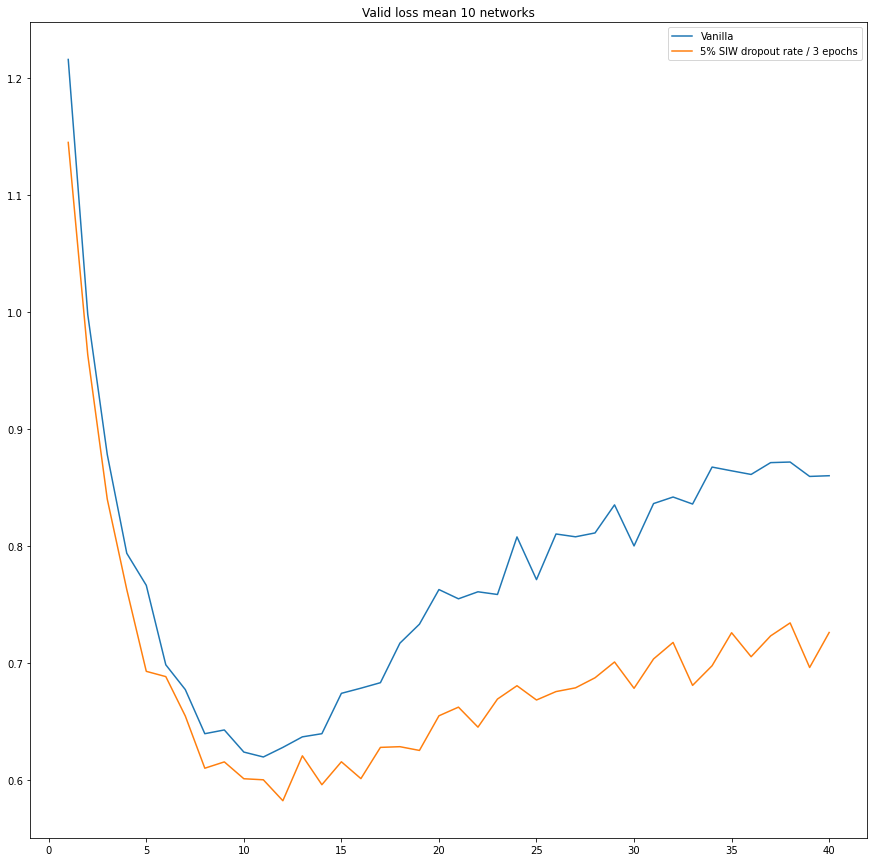

In [81]:
fig11, axs11 = plt.subplots(1)
axs11.set_title('Valid loss mean 10 networks')
fig11.set_figheight(15)
fig11.set_figwidth(15)
x___ = list(range(1,41))
labels3 = ['Vanilla', '5% SIW dropout rate / 3 epochs']
axs11.plot(x___, results_vanilla_FINAL_mean['Valid_loss_mean'], label = labels3[0])
axs11.plot(x___, results_SIW_05_every3epoch_FINAL_mean['Valid_loss_mean'], label = labels3[1])
axs11.legend()


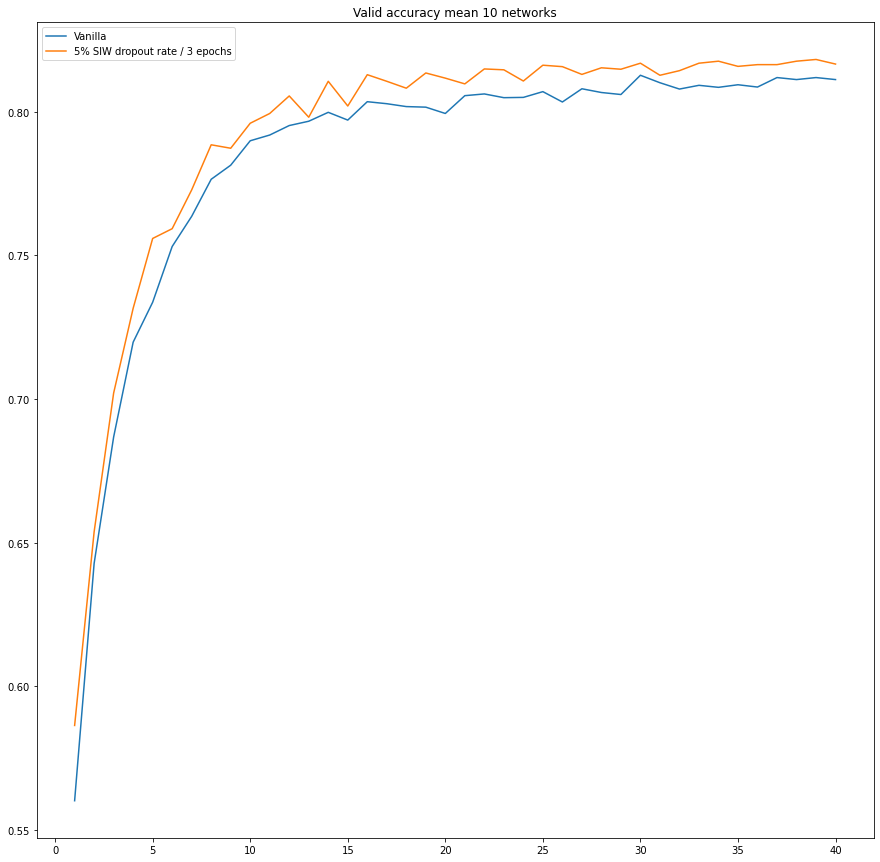

In [82]:
fig12, axs12 = plt.subplots(1)
axs12.set_title('Valid accuracy mean 10 networks')
fig12.set_figheight(15)
fig12.set_figwidth(15)
axs12.plot(x___, results_vanilla_FINAL_mean['Valid_accuracy_mean'], label = labels3[0])
axs12.plot(x___, results_SIW_05_every3epoch_FINAL_mean['Valid_accuracy_mean'], label = labels3[1])
axs12.legend()
